In [54]:
import os
import zipfile
import pandas as pd
import numpy as np
import magic
import os 
import umap
import statistics
from scipy.stats import spearmanr
import harmonypy as hm
from sklearn.cluster import KMeans, AgglomerativeClustering
import sklearn.decomposition as skd
from sklearn.metrics import silhouette_score, adjusted_rand_score, v_measure_score
import matplotlib.pyplot as plt
import scanpy as sc
import optuna
import scprep

In [22]:
# set seed
np.random.seed(127)

# Step 0: Download the training data

In [23]:
# get current path 
path_data = os.getcwd() 

### Training data information

In [24]:
bulk_pancreas = pd.read_csv(os.path.join(path_data,"train_data","pancreas_bulk_train.csv")).set_index("level_0")

In [25]:
print(f"Number of patients in the train dataset {bulk_pancreas.shape[1]}")
print(f"Number of genes in the dataset {bulk_pancreas.shape[0]}")

Number of patients in the train dataset 4
Number of genes in the dataset 25453


In [26]:
sc_pancreas = pd.read_csv(os.path.join(path_data,"train_data","pancreas_sc_train.csv")).set_index("Unnamed: 0")

In [27]:
assert bulk_pancreas.shape[0] == sc_pancreas.shape[0]
print(f"Number of cells in the train dataset {sc_pancreas.shape[1]}")

Number of cells in the train dataset 978


In [28]:
sc_pancreas_test = pd.read_csv(os.path.join(path_data,"test_data","pancreas_sc_test.csv")).set_index("Unnamed: 0")

In [29]:
print(f"Number of cells in the test dataset {sc_pancreas_test.shape[1]}")

Number of cells in the test dataset 789


In [30]:
sc_pancreas_metadata = pd.read_csv(os.path.join(path_data,"train_data","pancreas_sc_metadata_train.csv")).set_index("Source Name")

In [31]:
for patient in sc_pancreas_metadata.Sample.unique():
    print(f"Number of cells for {patient} is {sc_pancreas_metadata[sc_pancreas_metadata.Sample==patient].shape[0]}")

Number of cells for patient1 is 249
Number of cells for patient3 is 219
Number of cells for patient2 is 234
Number of cells for patient4 is 276


In [32]:
for dis in sc_pancreas_metadata.Disease.unique():
    df = sc_pancreas_metadata[sc_pancreas_metadata.Disease==dis]
    print(f"There are {df.Sample.nunique()} train patients with {dis}")

There are 2 train patients with type II diabetes mellitus
There are 2 train patients with normal


In [13]:
print(f"There are {df.Celltype.nunique()} different cell types in the dataset")
print(f"The different cells types are {df.Celltype.unique()}")

There are 11 different cell types in the dataset
The different cells types are ['delta cell' 'alpha cell' 'beta cell' 'PSC cell' 'endothelial cell'
 'gamma cell' 'co-expression cell' 'ductal cell' 'epsilon cell'
 'unclassified endocrine cell' 'acinar cell']


In [14]:
sc_pancreas_metadata.Celltype.nunique()

13

### Test data information

In [33]:
sc_pancreas_metadata_test = pd.read_csv(os.path.join(path_data,"test_data","pancreas_sc_metadata_test_wocelltype.csv")).set_index("Source Name")

In [34]:
for patient in sc_pancreas_metadata_test.Sample.unique():
    print(f"Number of cells for {patient} is {sc_pancreas_metadata_test[sc_pancreas_metadata_test.Sample==patient].shape[0]}")

Number of cells for patient5 is 203
Number of cells for patient7 is 284
Number of cells for patient6 is 302


In [35]:
for dis in sc_pancreas_metadata_test.Disease.unique():
    df = sc_pancreas_metadata_test[sc_pancreas_metadata_test.Disease==dis]
    print(f"There are {df.Sample.nunique()} test patients with {dis}")

There are 1 test patients with normal
There are 2 test patients with type II diabetes mellitus


Dropout in Single cell data: When a gene is observed at a moderate or high expression level in one cell but not detected in another cell. An expressed transcript is not detected. 
- reasons for dropout: biological, or non-biological. 
- biological: indicates information about cell states
- non-biological: technical zeros, which occur during the preparation of biological samples for sequencing, and sampling zeros, which arise due to limited sequencing depths

Good imputation methods for single cell data
- should achieve: 
1. accurate estimation of missing values
- should avoid: 
1. overfitting or oversmoothing: could lead to loss of biological information or variability 
2. loss of sparsity

Samples  processed by different technicians and/or at different time points could lead to batch effect
- how batch effect may affect single cell data: could lead to variation in sample groups that are caused by technical arrangements rather than biological factors, which could lead to false conclusions 
- methods to overcome potentially confounding effects: eliminate technical noise or bias so that observed variance in gene expression variance primarily reflects true biological variance.
- use some batch correction algorithms: ex: MNN, CCA, Harmony 


# Step 1: Perform the imputation

Methods to try for imputation 
- MAGIC
- ZINB VAE AND ZINB CVAE helps impute dropout effect

- calculating the "bulkified" data means calculating the patient-wide average of gene expression (ex: avg SGIP1 exp for patient1, 2, 3, 4)
- To get the gene expression for patient j, you must simply average the library size-corrected values of the gene expression over all cells of the same patient.
- average spearman's correlation will be calculated for all patients in the test set 

In [48]:
def bulkification(sc_data):
    patient_ids = sorted(list(set([col.split('_')[0] for col in sc_data.columns])))
    bulkified = pd.DataFrame(columns=patient_ids, index=sc_data.index)
    for patient_id in patient_ids:
        # Select columns belonging to the same patient
        patient_columns = [col for col in sc_data.columns if col.startswith(patient_id)]
        patient_data = sc_data[patient_columns]
        
        # Calculate the mean expression for each gene for the current patient
        mean_expression = patient_data.mean(axis=1)
        bulkified[patient_id] = mean_expression
    return bulkified

In [49]:
def calc_spearman(log_transformed_bulk_data, bulkified):
    patient_ids = sorted(list(set([col.split('_')[0] for col in bulkified.columns])))
    spearman_correlations = []
    for patient_id in patient_ids:
        spearman_correlation = spearmanr(log_transformed_bulk_data[patient_id], bulkified[patient_id])[0]
        spearman_correlations.append(spearman_correlation)
    return spearman_correlations

Method 1: trying with just training data, using parameters found by optuna 

In [50]:
def objective(trial, sc_pancreas, bulk_pancreas):
    # Suggest values for parameters
    knn = trial.suggest_int("knn", 3, 15)
    decay = trial.suggest_float("decay", 1, 10, log=True)
    t = trial.suggest_int("t", 1, 10)
    n_pca = trial.suggest_int("n_pca", 10, 200)

    # Normalize the data
    sc_pancreas_imputed_train_ad = sc.AnnData(sc_pancreas.T)
    sc.pp.normalize_total(sc_pancreas_imputed_train_ad, target_sum=1e4)

    # Filter out genes not expressed in any cell
    filtgene_train = sc.pp.filter_genes(sc_pancreas_imputed_train_ad, inplace=False, min_cells=3)
    filtcell_train = sc.pp.filter_cells(sc_pancreas_imputed_train_ad, inplace=False, min_genes=200)

    # Create normalized DataFrame
    sc_pancreas_train_norm = pd.DataFrame(sc_pancreas_imputed_train_ad.X.T,
                                          columns= sc_pancreas.columns,
                                          index= sc_pancreas.index)

    # Apply filters
    filtered_train = sc_pancreas_train_norm.loc[filtgene_train[0], :]
    filtered_train = filtered_train.loc[:, filtcell_train[0]]
    filtered_train_out = sc_pancreas_train_norm.loc[~filtgene_train[0], :]

    # Initialize MAGIC with suggested parameters
    magic_operator = magic.MAGIC(
        knn=knn, decay=decay, t=t, n_pca=n_pca
    )

    # Perform imputation on filtered data
    sc_pancreas_imputed = magic_operator.fit_transform(filtered_train.T).T

    # Add back in genes that were filtered out
    sc_pancreas_imputed = sc_pancreas_imputed.set_index(filtered_train.index)
    sc_pancreas_imputed = pd.concat([sc_pancreas_imputed, filtered_train_out], axis = 0, join= 'inner')

    # Order the columns to sc_pancreas_imputed to match sc_pancreas
    sc_pancreas_imputed = sc_pancreas_imputed.loc[sc_pancreas_train_norm.index, :]

    # Bulkify and calculate Spearman correlation
    bulkified_train = bulkification(sc_pancreas_imputed)
    log_transformed_bulk_data = np.log2(bulk_pancreas + 1)
    spearman_correlations = calc_spearman(log_transformed_bulk_data, bulkified_train)

    # Return the negative mean Spearman correlation (Optuna minimizes the objective)
    return -statistics.mean(spearman_correlations)


In [41]:
# normalization of training data 
sc_pancreas_imputed_train_ad = sc.AnnData(sc_pancreas.T)
sc.pp.normalize_total(sc_pancreas_imputed_train_ad, target_sum=1e4)

# filter for genes that aren't expressed in any cell 
filtgene_train = sc.pp.filter_genes(sc_pancreas_imputed_train_ad, inplace=False, min_cells=3)
filtcell_train = sc.pp.filter_cells(sc_pancreas_imputed_train_ad, inplace=False, min_genes=200)

sc_pancreas_train_norm = pd.DataFrame(sc_pancreas_imputed_train_ad.X.T,
                                      columns= sc_pancreas.columns,
                                      index= sc_pancreas.index)

filtered_train = sc_pancreas_train_norm.loc[filtgene_train[0], :]
filtered_train = filtered_train.loc[:, filtcell_train[0]]

filtered_train_out = sc_pancreas_train_norm.loc[~filtgene_train[0], :]

magic_operator = magic.MAGIC()
sc_pancreas_imputed = magic_operator.fit_transform(filtered_train.T).T

# add back in genes that were filtered out
sc_pancreas_imputed = sc_pancreas_imputed.set_index(filtered_train.index)
sc_pancreas_imputed = pd.concat([sc_pancreas_imputed, filtered_train_out], axis = 0, join= 'inner')

# order the columns to sc_pancreas_imputed to match sc_pancreas
sc_pancreas_imputed = sc_pancreas_imputed.loc[sc_pancreas_train_norm.index, :]

# check if columns are the same
assert(sc_pancreas_imputed.index == sc_pancreas_train_norm.index).all()
assert(sc_pancreas_imputed.columns == sc_pancreas_train_norm.columns).all()


# bulkifying and calculating spearman correlation
bulkified_train = bulkification(sc_pancreas_imputed)
log_transformed_bulk_data = np.log2(bulk_pancreas + 1)
spearman_correlations = calc_spearman(log_transformed_bulk_data, bulkified_train)
print(statistics.mean(spearman_correlations))

Calculating MAGIC...
  Running MAGIC on 978 cells and 19854 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 3.73 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.08 seconds.
    Calculating affinities...
    Calculated affinities in 0.13 seconds.
  Calculated graph and diffusion operator in 3.98 seconds.
  Running MAGIC with `solver='exact'` on 19854-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.
  Calculating imputation...
  Calculated imputation in 0.49 seconds.
Calculated MAGIC in 4.54 seconds.
0.9481337494139936


Method 2: Trying with both train and test data

In [121]:
# concatenate columns of sc_pancreas and sc_pancreas_test together according to index
sc_pancreas_train_test = pd.concat([sc_pancreas, sc_pancreas_test], axis=1, join='inner')

# normalization
sc_pancreas_imputed_train_test_ad = sc.AnnData(sc_pancreas_train_test.T)
sc.pp.normalize_total(sc_pancreas_imputed_train_test_ad, target_sum=1e4)

# filter for genes that are not expressed in any cell
filtgene = sc.pp.filter_genes(sc_pancreas_imputed_train_test_ad, inplace=False, min_cells= 3)
filtcell = sc.pp.filter_cells(sc_pancreas_imputed_train_test_ad, inplace=False, min_genes= 200)

sc_pancreas_train_test_norm = pd.DataFrame(sc_pancreas_imputed_train_test_ad.X.T,
                                                    columns= sc_pancreas_train_test.columns,
                                                    index= sc_pancreas_train_test.index)

filtered = sc_pancreas_train_test_norm.loc[filtgene[0], :]
filtered = filtered.loc[:, filtcell[0]]

filtered_out = sc_pancreas_train_test_norm.loc[~filtgene[0], :]

# magic imputation on filtered data
magic_operator = magic.MAGIC()
sc_pancreas_train_test_norm_filt_magic = magic_operator.fit_transform(filtered.T).T

# add back in genes that were filtered out because they were false in filtgene[0]
sc_pancreas_train_test_norm_filt_magic = sc_pancreas_train_test_norm_filt_magic.set_index(filtered.index)
sc_pancreas_train_test_norm_filt_magic = pd.concat([sc_pancreas_train_test_norm_filt_magic, filtered_out], axis= 0, join= 'inner')

# order the columns of sc_pancreas_train_test_norm_filt_magic to match sc_pancreas_train_test_norm
sc_pancreas_train_test_norm_filt_magic = sc_pancreas_train_test_norm_filt_magic.loc[sc_pancreas_train_test_norm.index,:]

# check if columns are the same
assert(sc_pancreas_train_test_norm_filt_magic.index == sc_pancreas_train_test_norm.index).all()
assert(sc_pancreas_train_test_norm_filt_magic.columns == sc_pancreas_train_test_norm.columns).all()

# select out for test data 
sc_pancreas_all_imp = sc_pancreas_train_test_norm_filt_magic[sc_pancreas.columns]
sc_pancreas_all_imp_bulk = bulkification(sc_pancreas_all_imp)
spearman_all = calc_spearman(log_transformed_bulk_data, sc_pancreas_all_imp_bulk)
print(statistics.mean(spearman_all))

# from now on for imputed data use sc_pancreas_all_imp


Calculating MAGIC...
  Running MAGIC on 1767 cells and 20640 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 7.04 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.25 seconds.
    Calculating affinities...
    Calculated affinities in 0.19 seconds.
  Calculated graph and diffusion operator in 7.53 seconds.
  Running MAGIC with `solver='exact'` on 20640-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.
  Calculating imputation...
  Calculated imputation in 1.01 seconds.
Calculated MAGIC in 8.63 seconds.
0.9525114973849284


In [ ]:
# Create a study and optimize the parameters using Optuna
# ONLY RUN IF YOU WANT TO OPTIMIZE FOR PARAMETERS
study = optuna.create_study()
study.optimize(lambda trial: objective(trial, sc_pancreas, bulk_pancreas), n_trials=100)

# Print the best parameters and the corresponding mean Spearman correlation
print("Best parameters:", study.best_params)
print("Best mean Spearman correlation:", -study.best_value)

In [122]:
# rerunning with best parameters found by optuna 
best_magic_operator = magic.MAGIC(knn=4, decay = 1.0865, t= 10, n_pca= 165)
sc_pancreas_train_test_norm_filt_magic_best = best_magic_operator.fit_transform(filtered.T).T

# add back in genes that were filtered out because they were false in filtgene[0]
sc_pancreas_train_test_norm_filt_magic_best = sc_pancreas_train_test_norm_filt_magic_best.set_index(filtered.index)
sc_pancreas_train_test_norm_filt_magic_best = pd.concat([sc_pancreas_train_test_norm_filt_magic_best, filtered_out], axis= 0, join= 'inner')

# order the columns of sc_pancreas_train_test_norm_filt_magic to match sc_pancreas_train_test_norm
sc_pancreas_train_test_norm_filt_magic_best = sc_pancreas_train_test_norm_filt_magic_best.loc[sc_pancreas_train_test_norm.index,:]

# check if columns are the same
assert(sc_pancreas_train_test_norm_filt_magic_best.index == sc_pancreas_train_test_norm.index).all()
assert(sc_pancreas_train_test_norm_filt_magic_best.columns == sc_pancreas_train_test_norm.columns).all()

# select out for test data 
sc_pancreas_all_imp = sc_pancreas_train_test_norm_filt_magic_best[sc_pancreas.columns]
sc_pancreas_all_imp_bulk = bulkification(sc_pancreas_all_imp)
spearman_all = calc_spearman(log_transformed_bulk_data, sc_pancreas_all_imp_bulk)
print(statistics.mean(spearman_all))

Calculating MAGIC...
  Running MAGIC on 1767 cells and 20640 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 9.26 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.36 seconds.
    Calculating affinities...
    Calculated affinities in 0.29 seconds.
  Calculated graph and diffusion operator in 10.02 seconds.
  Running MAGIC with `solver='exact'` on 20640-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.
  Calculating imputation...
  Calculated imputation in 1.49 seconds.
Calculated MAGIC in 11.73 seconds.
0.9531716134926624


Method 3: different normalization methods

In [68]:
# scprep.plot.plot_library_size(sc_pancreas, cutoff=1500)

sc_pancreas_cutoff = scprep.filter.filter_library_size(sc_pancreas, cutoff= 1500)

# Store the genes that were removed
filtered_genes = set(sc_pancreas.index) - set(sc_pancreas_cutoff.index)

sc_pancreas_cutoff_norm = scprep.normalize.library_size_normalize(sc_pancreas_cutoff)
sc_pancreas_cutoff_norm = scprep.transform.sqrt(sc_pancreas_cutoff_norm)

sc_pancreas_cutoff_norm_imp = magic_operator.fit_transform(sc_pancreas_cutoff_norm.T).T

# Add the filtered genes back in as zero rows
for gene in filtered_genes:
    sc_pancreas_cutoff_norm_imp.loc[gene] = [0] * len(sc_pancreas_cutoff_norm_imp.columns)

# Reorder the rows to match the original order
sc_pancreas_cutoff_norm_imp = sc_pancreas_cutoff_norm_imp.loc[sc_pancreas.index, :]

# bulkify
sc_pancreas_cutoff_norm_imp_bulk = bulkification(sc_pancreas_cutoff_norm_imp)
spearman_all = calc_spearman(log_transformed_bulk_data, sc_pancreas_all_imp_bulk)
print(statistics.mean(spearman_all))


Calculating MAGIC...
  Running MAGIC on 978 cells and 992 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 1.31 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.12 seconds.
    Calculating affinities...
    Calculated affinities in 0.11 seconds.
  Calculated graph and diffusion operator in 1.56 seconds.
  Calculating imputation...
  Calculated imputation in 0.12 seconds.
Calculated MAGIC in 1.70 seconds.


Method 4: Trying different normalizaiton method on train+test

In [119]:
sc_pancreas_train_test_met4 = pd.concat([sc_pancreas, sc_pancreas_test], axis=1, join='inner')

# normalize 
sc_pancreas_train_test_met4_cutoff = scprep.filter.filter_library_size(sc_pancreas_train_test_met4, cutoff= 1500)

# store the genes that were removed
filtered_genes_met4 = set(sc_pancreas_train_test_met4.index) - set(sc_pancreas_train_test_met4_cutoff.index)

sc_pancreas_train_test_met4_cutoff_norm = scprep.normalize.library_size_normalize(sc_pancreas_train_test_met4_cutoff)
sc_pancreas_train_test_met4_cutoff_norm = scprep.transform.sqrt(sc_pancreas_train_test_met4_cutoff_norm)

sc_pancreas_train_test_met4_cutoff_norm_imp = magic_operator.fit_transform(sc_pancreas_train_test_met4_cutoff_norm.T).T

# add the filtered genes back in as zero rows
for gene in filtered_genes_met4:
    sc_pancreas_train_test_met4_cutoff_norm_imp.loc[gene] = [0] * len(sc_pancreas_train_test_met4_cutoff_norm_imp.columns)

# reorder the rows to match the original order
sc_pancreas_train_test_met4_cutoff_norm_imp = sc_pancreas_train_test_met4_cutoff_norm_imp.loc[sc_pancreas_train_test_met4.index, :]

# select out for train data, and test data later in step 4
met4_imp = sc_pancreas_train_test_met4_cutoff_norm_imp[sc_pancreas.columns]
met4_imp_bulk = bulkification(met4_imp)
spearman_all = calc_spearman(log_transformed_bulk_data, met4_imp_bulk)
print(statistics.mean(spearman_all))



Calculating MAGIC...
  Running MAGIC on 1767 cells and 4035 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 3.60 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.19 seconds.
    Calculating affinities...
    Calculated affinities in 0.17 seconds.
  Calculated graph and diffusion operator in 3.99 seconds.
  Calculating imputation...
  Calculated imputation in 0.57 seconds.
Calculated MAGIC in 4.61 seconds.
0.5897249673693772


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<AxesSubplot:xlabel='Library size', ylabel='Number of cells'>

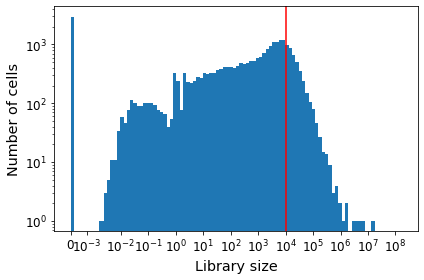

In [118]:
scprep.plot.plot_library_size(sc_pancreas_train_test_met4, cutoff=10000)


# Step 2: Perform clustering 

- clustering output can be performed on raw/imputed counts
- free to do whatever transformations on data

Batch correction methods
- regression based methods (ComBat)
- dimensionality reduction methods (Harmony, Seurat, iNMF)
- deep learning based models (BERMUDA, scVI, scVAE)

--> trying out LIGER, Harmony, Seurat 

### Parameters that could be tuned
- which preprocessing pipeline to use 
- whether to include harmony batch correction or not 
- which leiden resolution to use to obtain clusters

In [51]:
# calcluating scores 
def cluster_scoring(adata, leiden_res, sc_metadata):
    labels = adata.obs[leiden_res]
    # only select labels that have indices corresponding to sc_pancreas column name
    # make sure labels.index in sc_pancreas.columns
    # adding in this line bc we are using both train and test 
    labels = labels.loc[sc_pancreas.columns]

    ari = adjusted_rand_score(sc_metadata.Celltype, labels)
    v_measure = v_measure_score(sc_metadata.Celltype, labels)
    # TODO: not sure if ssc is accurate 
    adata_umap = adata.obsm["X_umap"]
    # pca on the umap
    adata_pca = skd.PCA(n_components=50).fit_transform(adata_umap)

    ssc = silhouette_score(adata.obsm["X_pca"][0:978,:], labels)
    # avg is the average of ari and v_measure
    avg = (ari + v_measure + ssc)/3
    print(f"resolution: {leiden_res}, ARI: {ari}, V-measure: {v_measure}, Silhouette score: {ssc}, Average: {avg}")
    return avg, ssc
    

In [89]:
def perform_clustering(adata, sc_pancreas_metadata, use_recipe, use_harmony_pca, leiden_resolution, imputed):
    # Create a copy of the input data to avoid modifying the original
    adata_copy = adata.copy()
    # print(adata_copy.X.shape)

    # Perform batch correction using Seurat recipe or basic preprocessing
    if use_recipe == 'seurat':
        # adding this line because imputed data is log transformed 
        if imputed:
            sc.pp.recipe_seurat(adata_copy, log= False)
        else:
            sc.pp.recipe_seurat(adata_copy, log= True)
    elif use_recipe == 'zheng':
        if imputed:
            # print(adata_copy.X.shape)
            sc.pp.recipe_zheng17(adata_copy, log = False, n_top_genes= 950)
        else:
            sc.pp.recipe_zheng17(adata_copy, log = True, n_top_genes= 3000)
    elif use_recipe == 'basic':
        if imputed: 
            pass
        else:
            sc.pp.filter_genes(adata_copy, min_cells=3)
            sc.pp.normalize_total(adata_copy, target_sum=1e4)
            sc.pp.log1p(adata_copy)
            sc.pp.highly_variable_genes(adata_copy, min_mean=0.0125, max_mean=3, min_disp=0.5)
            adata_copy = adata_copy[:, adata_copy.var['highly_variable']]
            sc.pp.scale(adata_copy, max_value=10)
    elif use_recipe == 'weinreb':
        if imputed:
            pass
        else:
            sc.pp.recipe_weinreb17(adata_copy, log = True)
    elif use_recipe == 'None':
        pass
    else:
        raise ValueError('Invalid recipe specified')
    
    # Calculate nearest neighbors
    sc.pp.neighbors(adata_copy, use_rep='X')
    # sc.tl.umap(adata_copy)

    if type(leiden_resolution) == list:
        for lr in leiden_resolution:
            leiden_key = 'leiden_res_raw' + str(lr)
            sc.tl.leiden(adata_copy, key_added = leiden_key, resolution=lr)
    else:
        leiden_key = 'leiden_res_raw' + str(leiden_resolution)
        sc.tl.leiden(adata_copy, key_added = leiden_key, resolution=leiden_resolution)

    # Perform PCA (this will be default X_pca if harmony not used)
    sc.tl.pca(adata_copy, n_comps= 50)
    
    # adding in cell type information
    if 'Celltype' in sc_pancreas_metadata.columns:
        adata_copy.obs['Celltype'] = sc_pancreas_metadata.Celltype

    # Use Harmony for batch-corrected PCA if requested
    if use_harmony_pca:
        harmony_pcs = hm.run_harmony(data_mat = adata_copy.obsm['X_pca'],
                                     meta_data = sc_pancreas_metadata,
                                     vars_use = ['Sample'],
                                     max_iter_harmony= 20, verbose=False
                                     )
        adata_copy.obsm['X_pca'] = harmony_pcs.Z_corr.T
    
    # Calculate nearest neighbors
    sc.tl.umap(adata_copy, n_components=50)
    # uncomment line below if you want to use umap as rep 
    # sc.pp.neighbors(adata_copy, n_pcs= 50, use_rep='X_umap')
    sc.pp.neighbors(adata_copy)
    

    # Perform Leiden clustering with specified resolution
    if type(leiden_resolution) == list:
        for lr in leiden_resolution:
            leiden_key = 'leiden_res_pc' + str(lr)
            sc.tl.leiden(adata_copy, key_added = leiden_key, resolution=lr)
    else:
        leiden_key = 'leiden_res_pc' + str(leiden_resolution)
        sc.tl.leiden(adata_copy, key_added = leiden_key, resolution=leiden_resolution)
    

    return adata_copy

Performing clustering with impute= True, recipe=seurat, harmony_pca=True


2023-04-30 22:58:58,032 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-04-30 22:58:58,473 - harmonypy - INFO - sklearn.KMeans initialization complete.


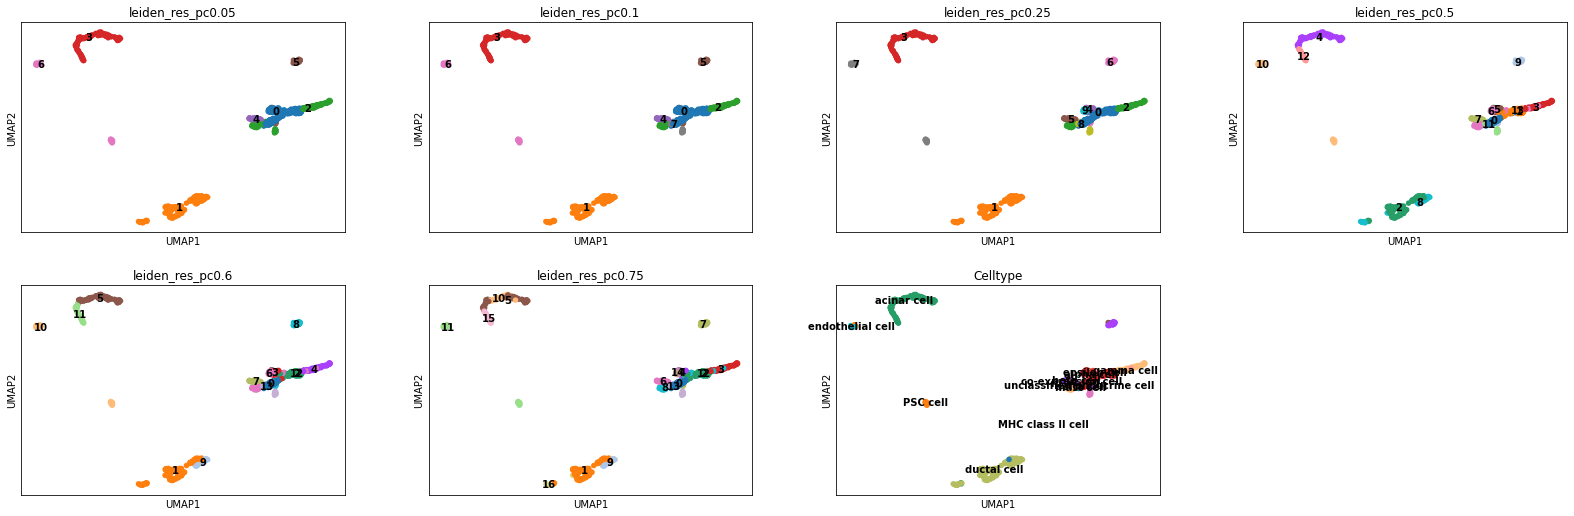

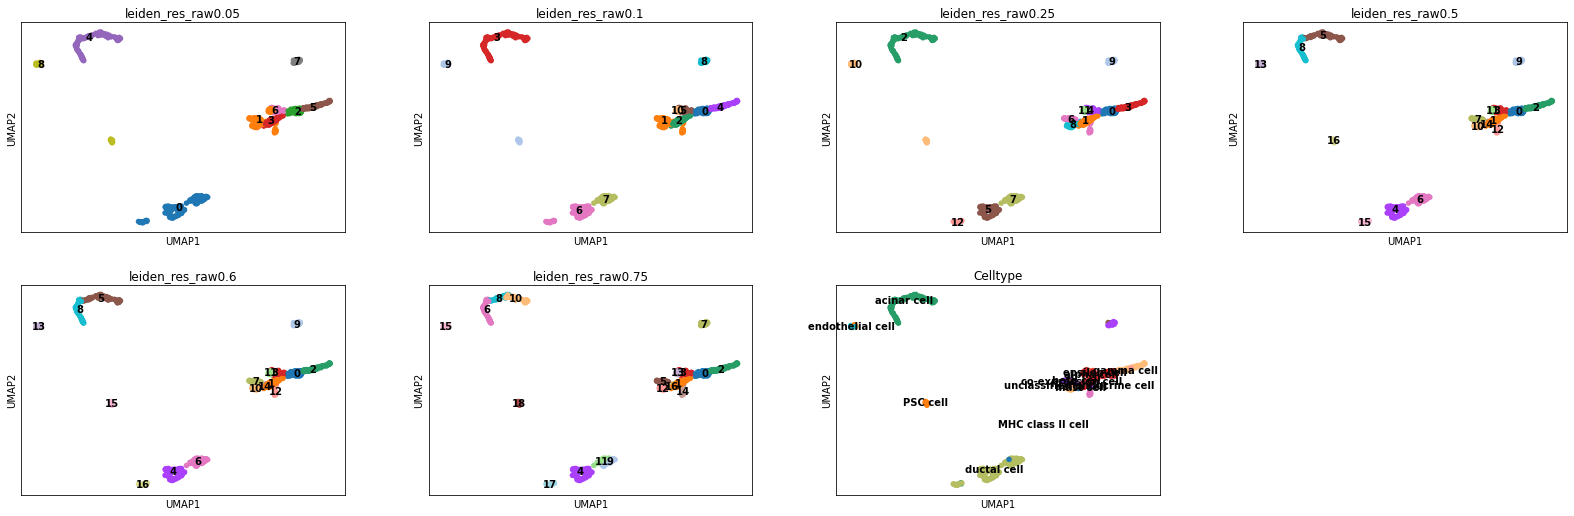

resolution: leiden_res_pc0.05, ARI: 0.9023281899625647, V-measure: 0.8727667924125807, Silhouette score: 0.6500154733657837, Average: 0.808370151913643
resolution: leiden_res_pc0.1, ARI: 0.9244306251229362, V-measure: 0.8958263569447782, Silhouette score: 0.6791049838066101, Average: 0.8331206552914415
resolution: leiden_res_pc0.25, ARI: 0.7364762387029063, V-measure: 0.8338011208338095, Silhouette score: 0.46856558322906494, Average: 0.6796143142552603
resolution: leiden_res_pc0.5, ARI: 0.45900357344027004, V-measure: 0.7360024930161081, Silhouette score: 0.29893940687179565, Average: 0.4979818244427246
resolution: leiden_res_pc0.6, ARI: 0.44577112562743093, V-measure: 0.7315887209992311, Silhouette score: 0.28606489300727844, Average: 0.4878082465446469
resolution: leiden_res_pc0.75, ARI: 0.4255004330311873, V-measure: 0.7280345676082378, Silhouette score: 0.3082500100135803, Average: 0.4872616702176685
Performing clustering with impute= True, recipe=seurat, harmony_pca=False


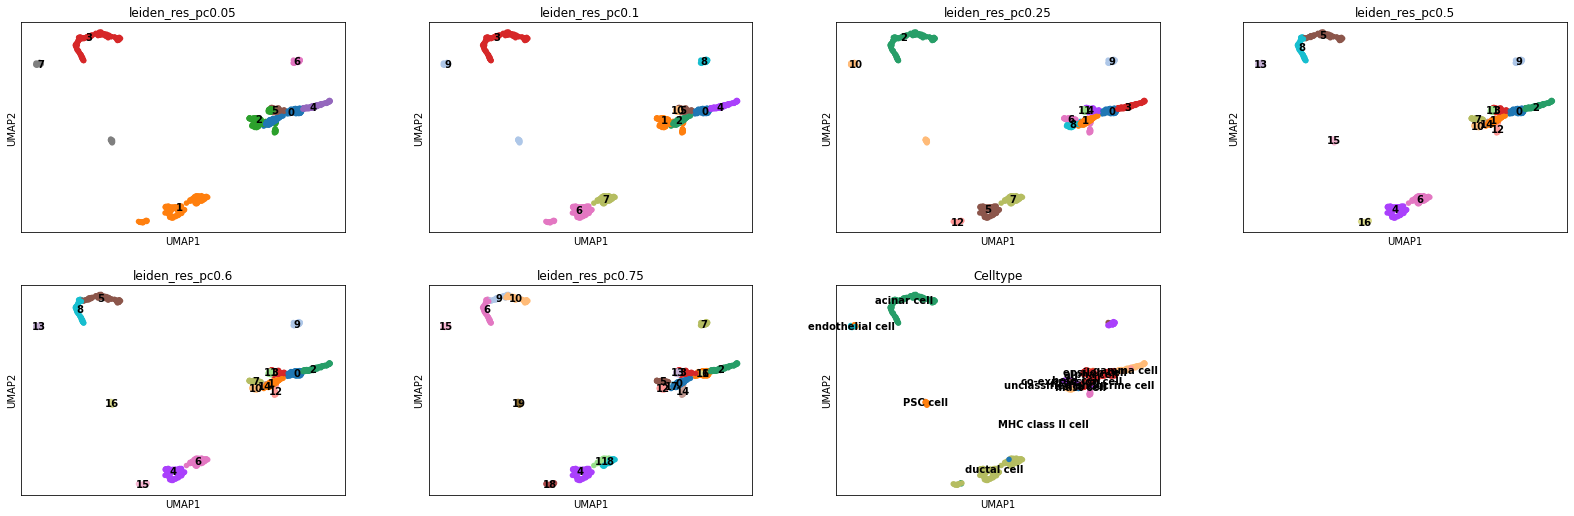

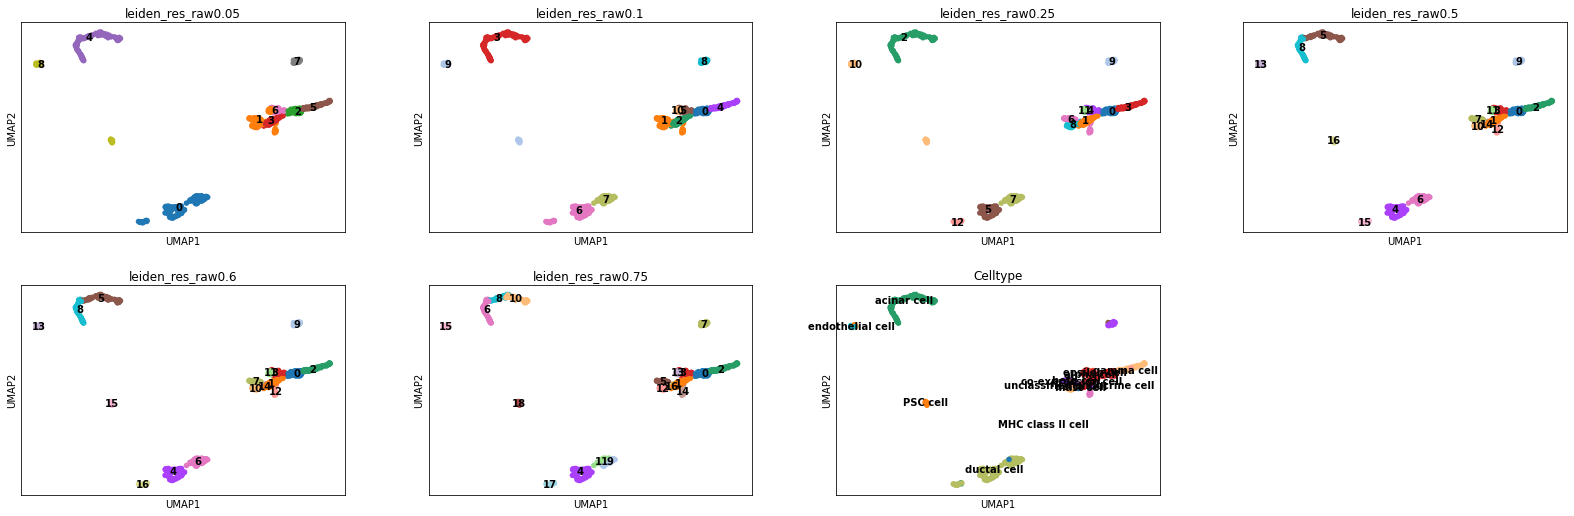

resolution: leiden_res_pc0.05, ARI: 0.6638078473467449, V-measure: 0.7631655228290324, Silhouette score: 0.5187409520149231, Average: 0.6485714407302335
resolution: leiden_res_pc0.1, ARI: 0.47987104511557227, V-measure: 0.7298105319550294, Silhouette score: 0.5258646011352539, Average: 0.5785153927352852
resolution: leiden_res_pc0.25, ARI: 0.48591045329497806, V-measure: 0.7392806578228698, Silhouette score: 0.563094437122345, Average: 0.596095182746731
resolution: leiden_res_pc0.5, ARI: 0.45417967823866845, V-measure: 0.7312188233171097, Silhouette score: 0.6240983009338379, Average: 0.603165600829872
resolution: leiden_res_pc0.6, ARI: 0.45417967823866845, V-measure: 0.7312188233171097, Silhouette score: 0.6240983009338379, Average: 0.603165600829872
resolution: leiden_res_pc0.75, ARI: 0.40428992636169925, V-measure: 0.7067391524157122, Silhouette score: 0.5621317625045776, Average: 0.5577202804273297
Performing clustering with impute= True, recipe=zheng, harmony_pca=True


2023-04-30 22:59:09,168 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-04-30 22:59:09,412 - harmonypy - INFO - sklearn.KMeans initialization complete.


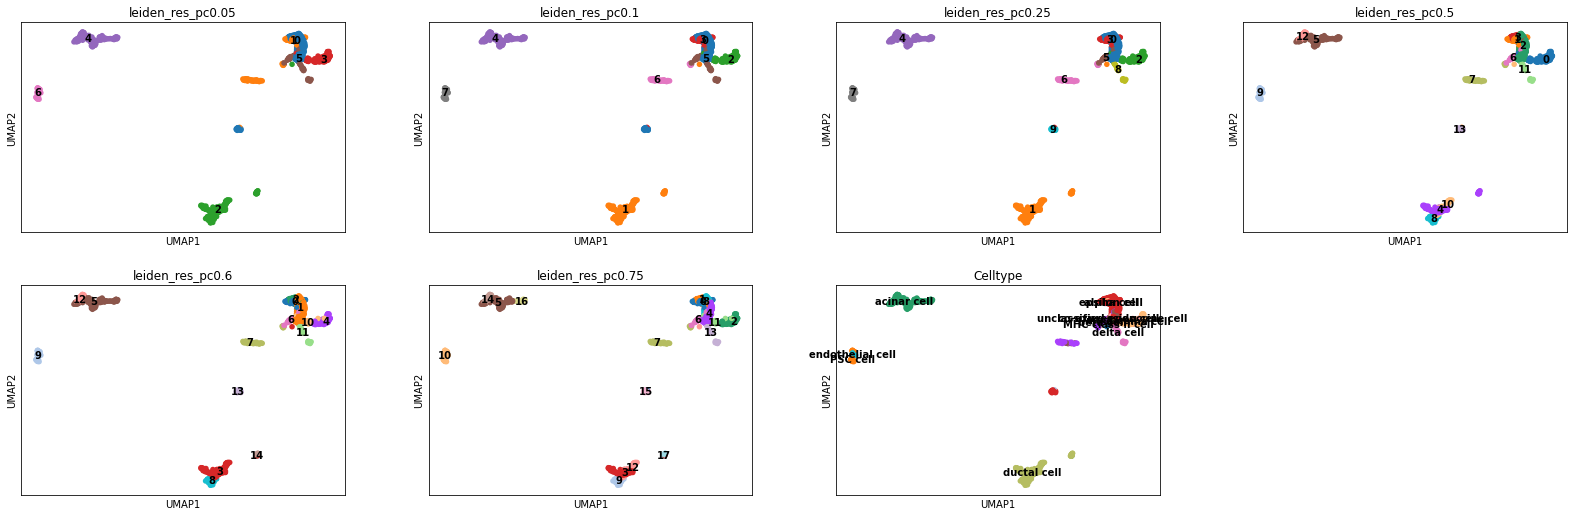

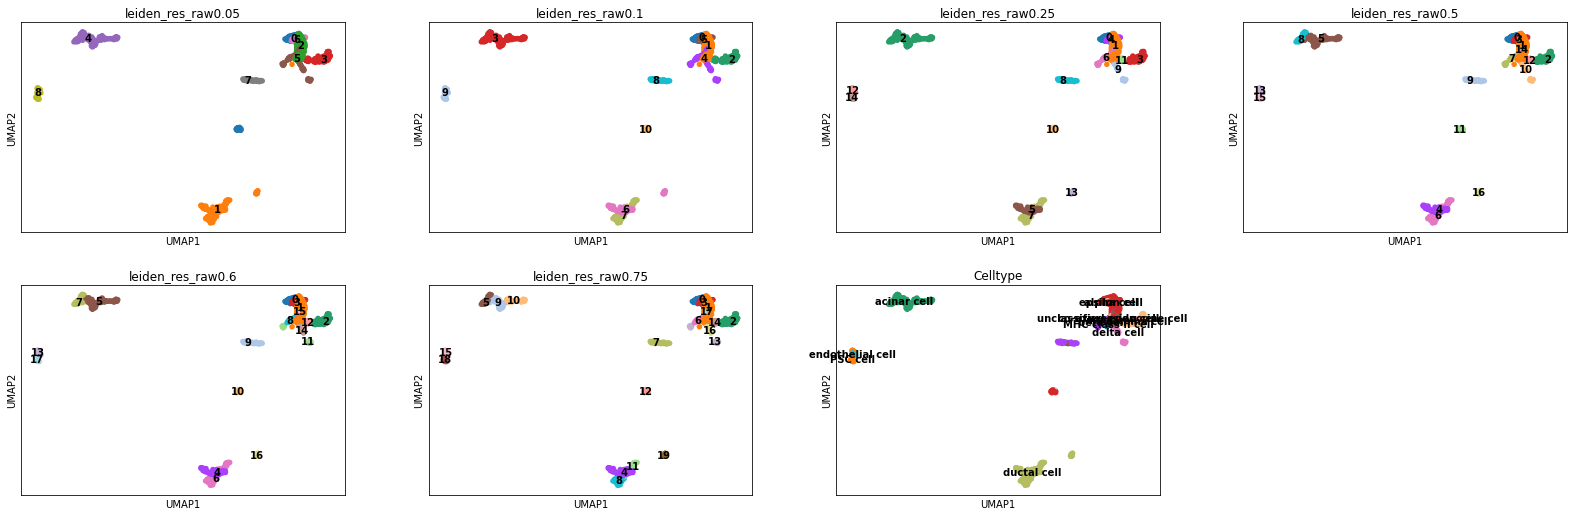

resolution: leiden_res_pc0.05, ARI: 0.6956441014850662, V-measure: 0.7982439085953217, Silhouette score: 0.5391846895217896, Average: 0.6776908998673924
resolution: leiden_res_pc0.1, ARI: 0.7280309208992302, V-measure: 0.8293832347000147, Silhouette score: 0.5828210711479187, Average: 0.7134117422490546
resolution: leiden_res_pc0.25, ARI: 0.6909432152210437, V-measure: 0.8269500832794068, Silhouette score: 0.46213293075561523, Average: 0.6600087430853553
resolution: leiden_res_pc0.5, ARI: 0.4754640878025082, V-measure: 0.7526110987043865, Silhouette score: 0.3713177740573883, Average: 0.533130986854761
resolution: leiden_res_pc0.6, ARI: 0.4691913109431888, V-measure: 0.7481202035446154, Silhouette score: 0.3296510577201843, Average: 0.5156541907359962
resolution: leiden_res_pc0.75, ARI: 0.4017566855991098, V-measure: 0.7182711602973989, Silhouette score: 0.3284190595149994, Average: 0.48281563513716935
Performing clustering with impute= True, recipe=zheng, harmony_pca=False


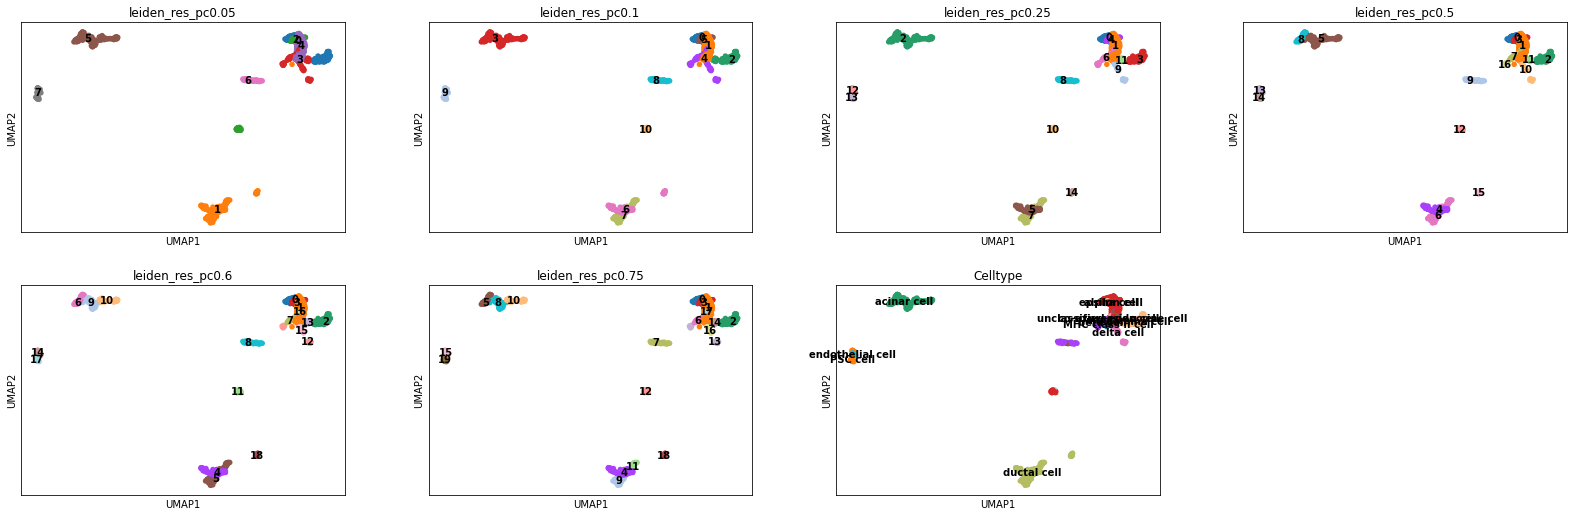

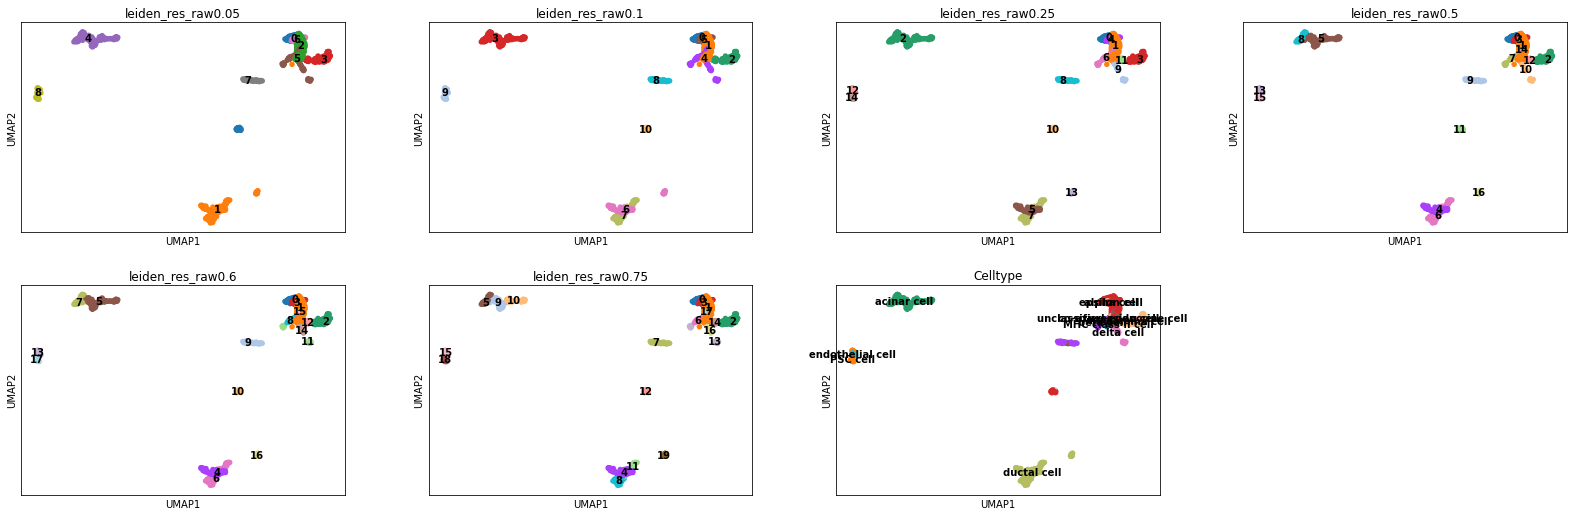

resolution: leiden_res_pc0.05, ARI: 0.48123037302660776, V-measure: 0.7049959958475537, Silhouette score: 0.3987840414047241, Average: 0.5283368034262952
resolution: leiden_res_pc0.1, ARI: 0.5104328709175288, V-measure: 0.7566238461608763, Silhouette score: 0.5163295269012451, Average: 0.5944620813265501
resolution: leiden_res_pc0.25, ARI: 0.49112758181749955, V-measure: 0.7548151060524391, Silhouette score: 0.5935376882553101, Average: 0.6131601253750829
resolution: leiden_res_pc0.5, ARI: 0.4556021018686961, V-measure: 0.7380003264994367, Silhouette score: 0.6023402214050293, Average: 0.5986475499243874
resolution: leiden_res_pc0.6, ARI: 0.43567763147343935, V-measure: 0.7159079293212351, Silhouette score: 0.5753166079521179, Average: 0.5756340562489308
resolution: leiden_res_pc0.75, ARI: 0.4244318046514782, V-measure: 0.7086502341348876, Silhouette score: 0.5695655941963196, Average: 0.5675492109942285
Performing clustering with impute= True, recipe=weinreb, harmony_pca=True


2023-04-30 22:59:21,736 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-04-30 22:59:22,535 - harmonypy - INFO - sklearn.KMeans initialization complete.


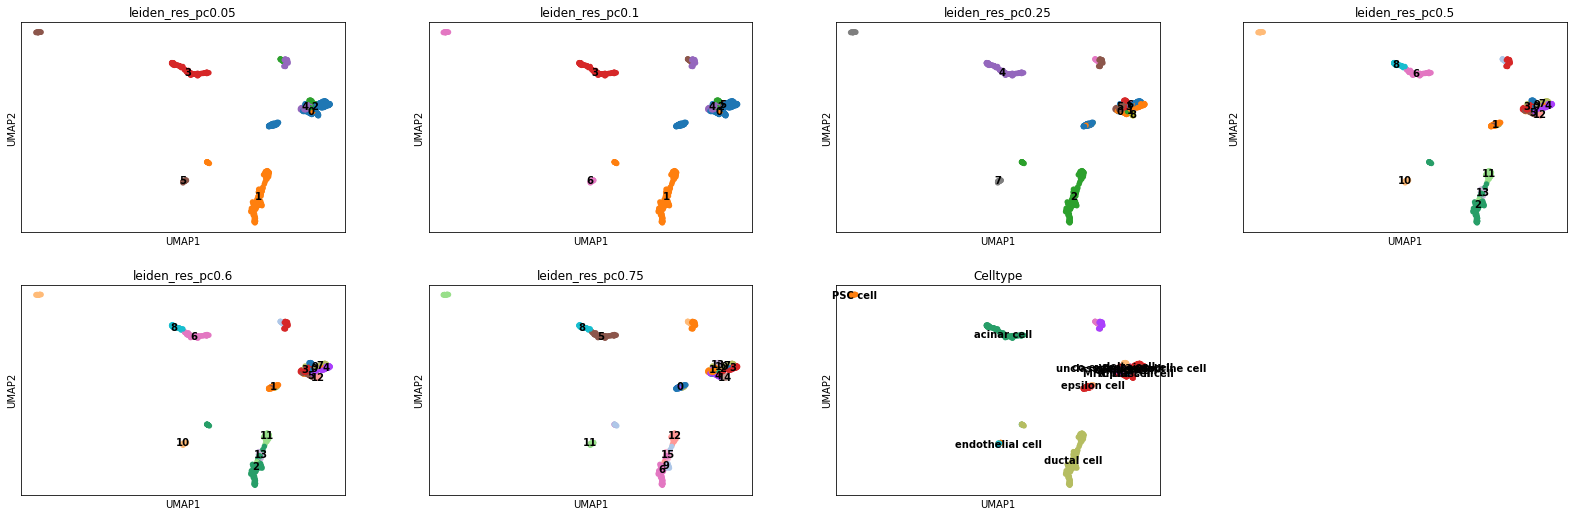

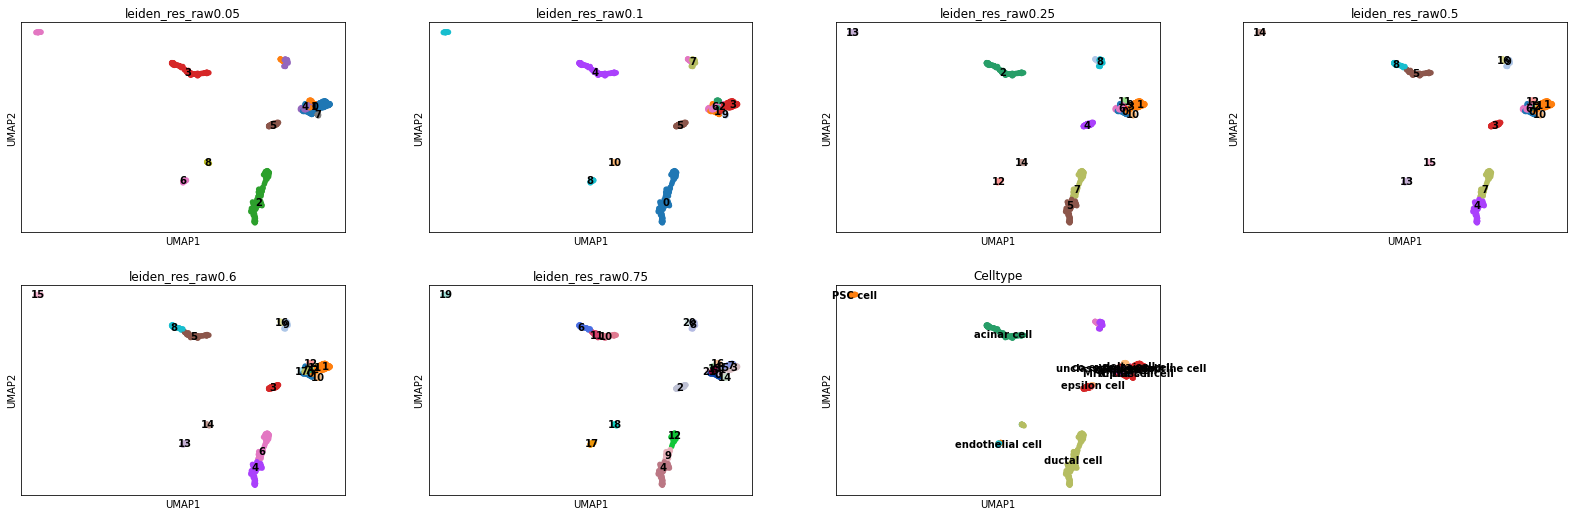

resolution: leiden_res_pc0.05, ARI: 0.9114956680321572, V-measure: 0.8940563508967089, Silhouette score: 0.6320561170578003, Average: 0.8125360453288888
resolution: leiden_res_pc0.1, ARI: 0.9378769433826504, V-measure: 0.9195130624566302, Silhouette score: 0.6647003293037415, Average: 0.8406967783810074
resolution: leiden_res_pc0.25, ARI: 0.6760141824534706, V-measure: 0.8394035368481946, Silhouette score: 0.49112898111343384, Average: 0.6688489001383663
resolution: leiden_res_pc0.5, ARI: 0.4550101336394276, V-measure: 0.751874148227689, Silhouette score: 0.35566890239715576, Average: 0.5208510614214241
resolution: leiden_res_pc0.6, ARI: 0.4550101336394276, V-measure: 0.751874148227689, Silhouette score: 0.35566890239715576, Average: 0.5208510614214241
resolution: leiden_res_pc0.75, ARI: 0.4046215594040079, V-measure: 0.730254177107595, Silhouette score: 0.31882989406585693, Average: 0.48456854352581996
Performing clustering with impute= True, recipe=weinreb, harmony_pca=False


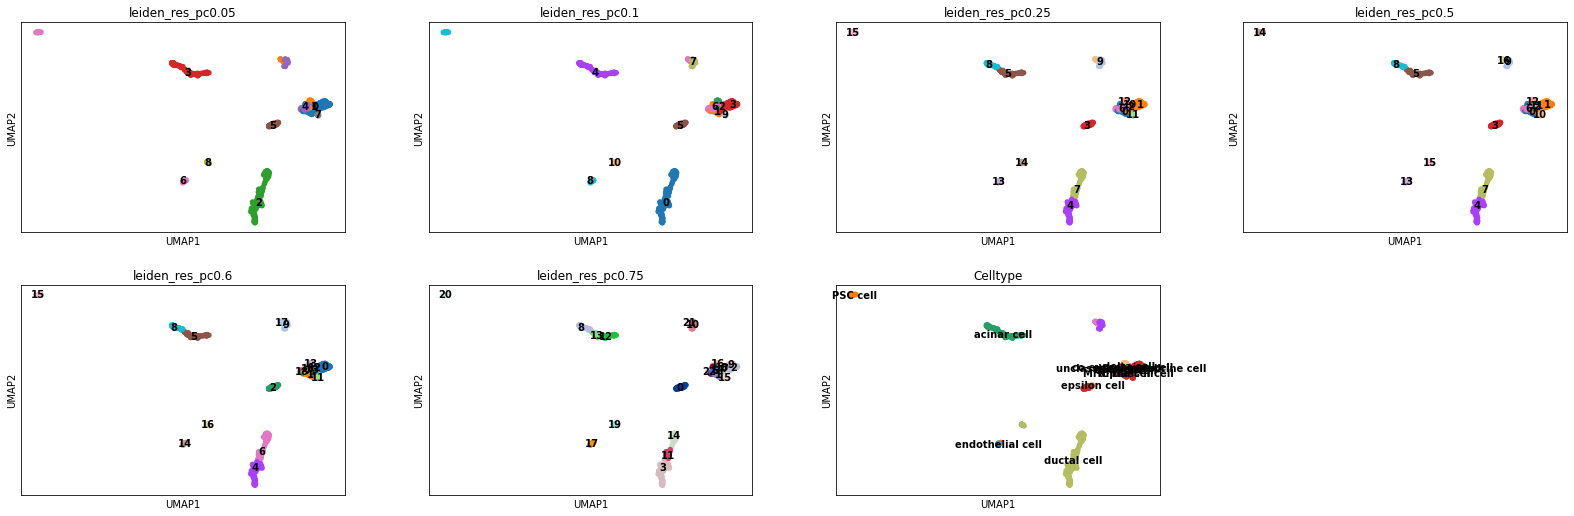

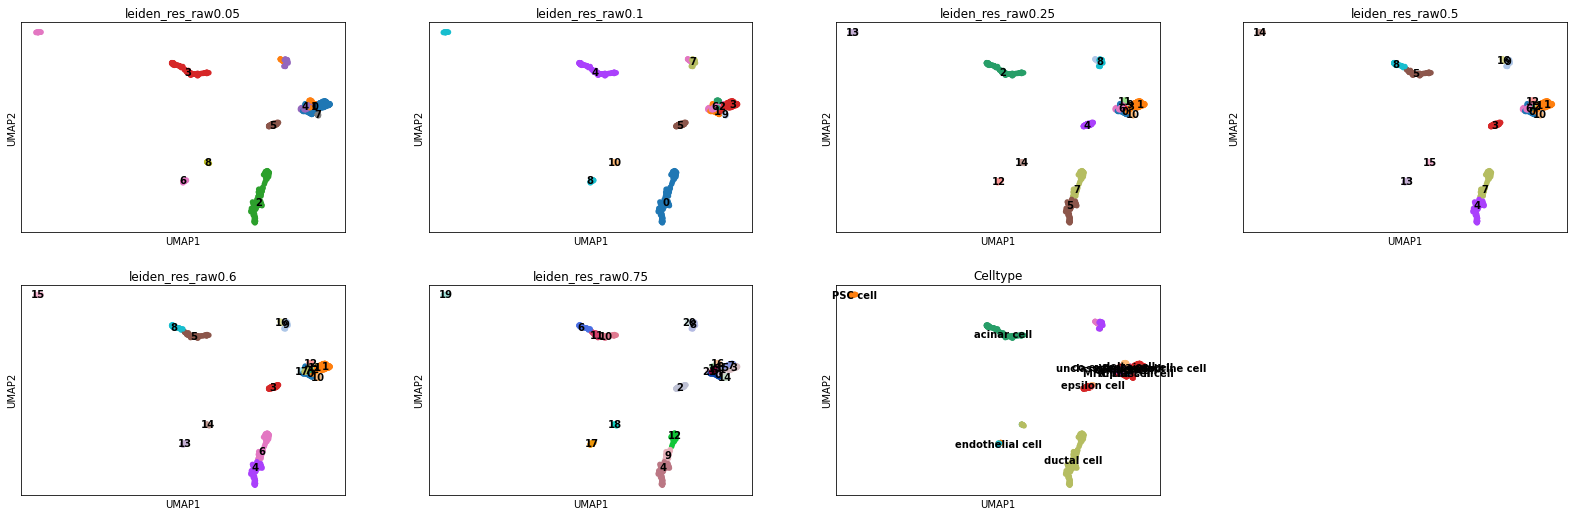

resolution: leiden_res_pc0.05, ARI: 0.6947585272623309, V-measure: 0.814588993193727, Silhouette score: 0.44130900502204895, Average: 0.6502188418260356
resolution: leiden_res_pc0.1, ARI: 0.5506728779500473, V-measure: 0.7704487400193498, Silhouette score: 0.5251448750495911, Average: 0.6154221643396628
resolution: leiden_res_pc0.25, ARI: 0.458188625004566, V-measure: 0.7431732102057342, Silhouette score: 0.5973938703536987, Average: 0.5995852351879997
resolution: leiden_res_pc0.5, ARI: 0.45944375404475474, V-measure: 0.7426325907971467, Silhouette score: 0.5987353920936584, Average: 0.60027057897852
resolution: leiden_res_pc0.6, ARI: 0.4229478804960432, V-measure: 0.7265834196416087, Silhouette score: 0.575415849685669, Average: 0.5749823832744403
resolution: leiden_res_pc0.75, ARI: 0.3165503235461279, V-measure: 0.6824786260633061, Silhouette score: 0.4788222312927246, Average: 0.49261706030071956
Performing clustering with impute= True, recipe=basic, harmony_pca=True


2023-04-30 22:59:38,915 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-04-30 22:59:40,470 - harmonypy - INFO - sklearn.KMeans initialization complete.


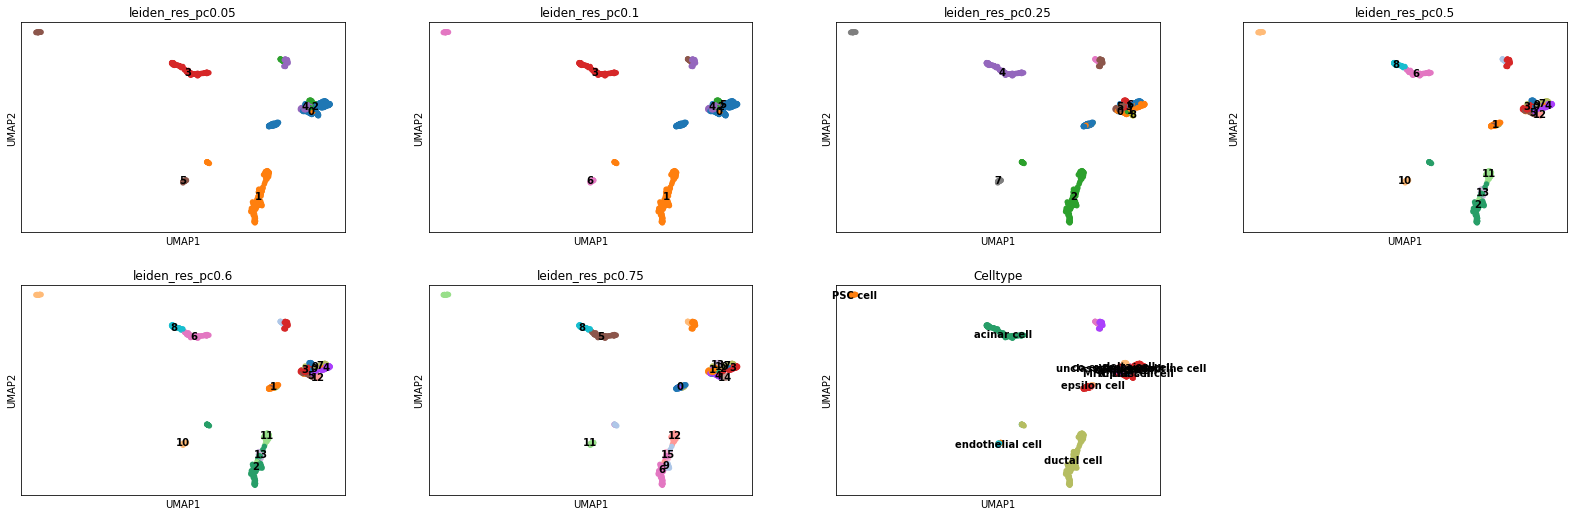

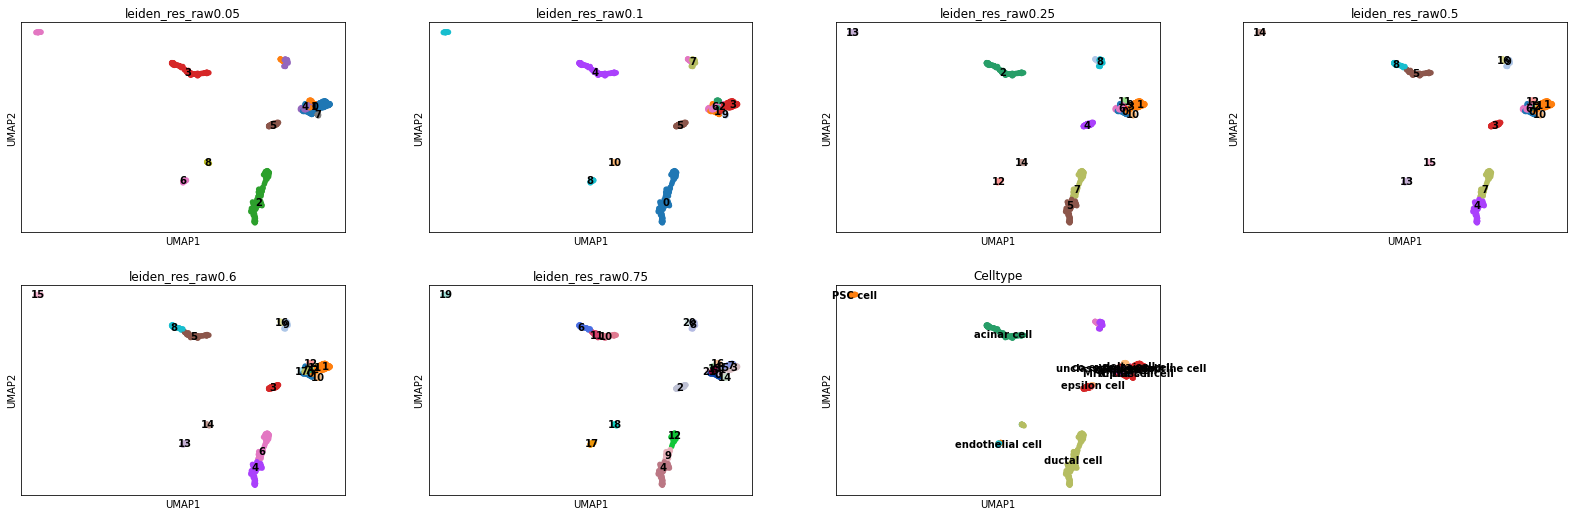

resolution: leiden_res_pc0.05, ARI: 0.9114956680321572, V-measure: 0.8940563508967089, Silhouette score: 0.6320561170578003, Average: 0.8125360453288888
resolution: leiden_res_pc0.1, ARI: 0.9378769433826504, V-measure: 0.9195130624566302, Silhouette score: 0.6647003293037415, Average: 0.8406967783810074
resolution: leiden_res_pc0.25, ARI: 0.6760141824534706, V-measure: 0.8394035368481946, Silhouette score: 0.49112898111343384, Average: 0.6688489001383663
resolution: leiden_res_pc0.5, ARI: 0.4550101336394276, V-measure: 0.751874148227689, Silhouette score: 0.35566890239715576, Average: 0.5208510614214241
resolution: leiden_res_pc0.6, ARI: 0.4550101336394276, V-measure: 0.751874148227689, Silhouette score: 0.35566890239715576, Average: 0.5208510614214241
resolution: leiden_res_pc0.75, ARI: 0.4046215594040079, V-measure: 0.730254177107595, Silhouette score: 0.31882989406585693, Average: 0.48456854352581996
Performing clustering with impute= True, recipe=basic, harmony_pca=False


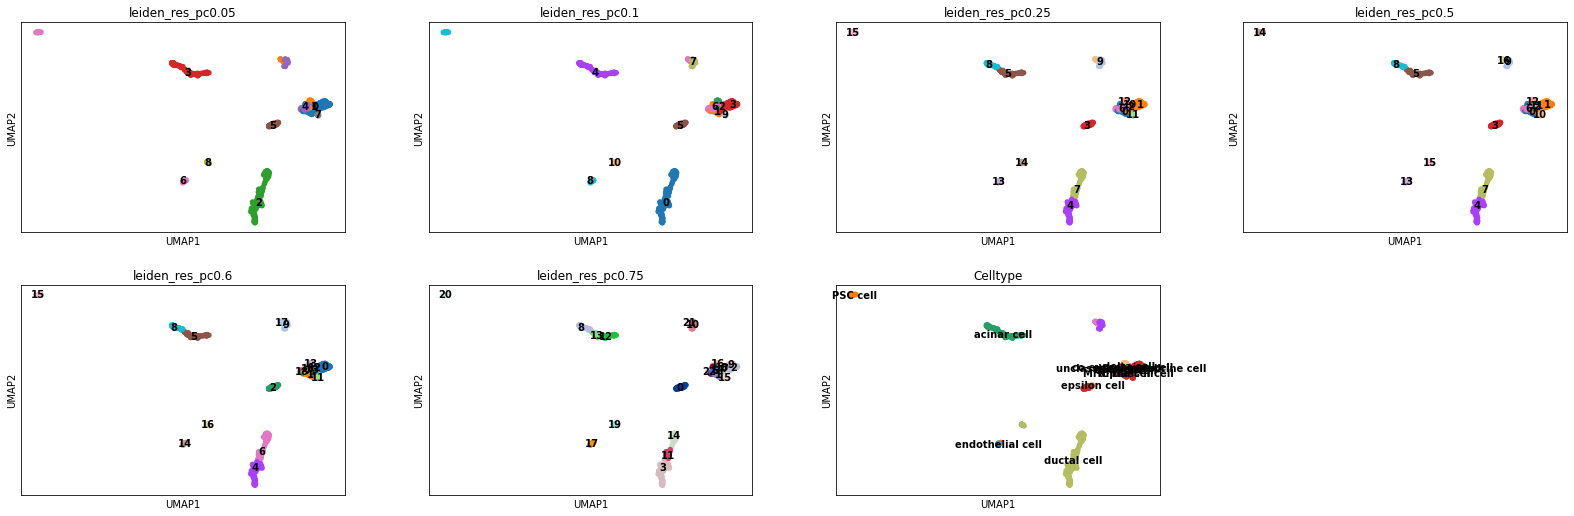

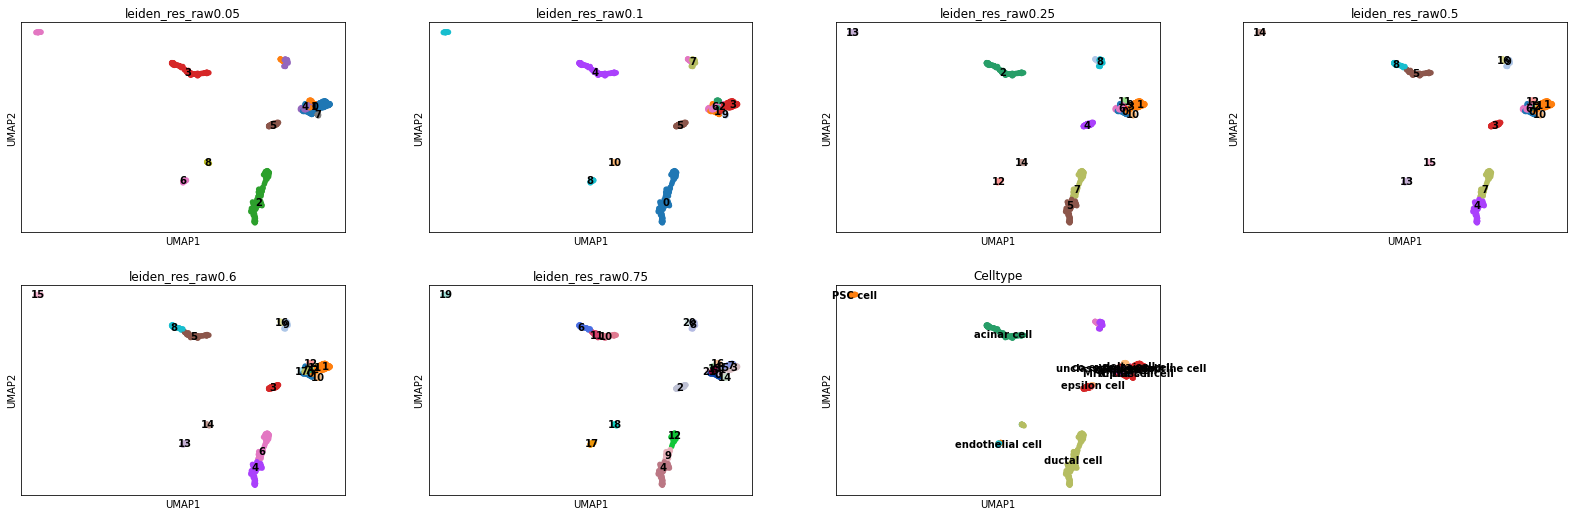

resolution: leiden_res_pc0.05, ARI: 0.6947585272623309, V-measure: 0.814588993193727, Silhouette score: 0.44130900502204895, Average: 0.6502188418260356
resolution: leiden_res_pc0.1, ARI: 0.5506728779500473, V-measure: 0.7704487400193498, Silhouette score: 0.5251448750495911, Average: 0.6154221643396628
resolution: leiden_res_pc0.25, ARI: 0.458188625004566, V-measure: 0.7431732102057342, Silhouette score: 0.5973938703536987, Average: 0.5995852351879997
resolution: leiden_res_pc0.5, ARI: 0.45944375404475474, V-measure: 0.7426325907971467, Silhouette score: 0.5987353920936584, Average: 0.60027057897852
resolution: leiden_res_pc0.6, ARI: 0.4229478804960432, V-measure: 0.7265834196416087, Silhouette score: 0.575415849685669, Average: 0.5749823832744403
resolution: leiden_res_pc0.75, ARI: 0.3165503235461279, V-measure: 0.6824786260633061, Silhouette score: 0.4788222312927246, Average: 0.49261706030071956
Performing clustering with impute= True, recipe=None, harmony_pca=True


2023-04-30 22:59:56,002 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-04-30 22:59:57,035 - harmonypy - INFO - sklearn.KMeans initialization complete.


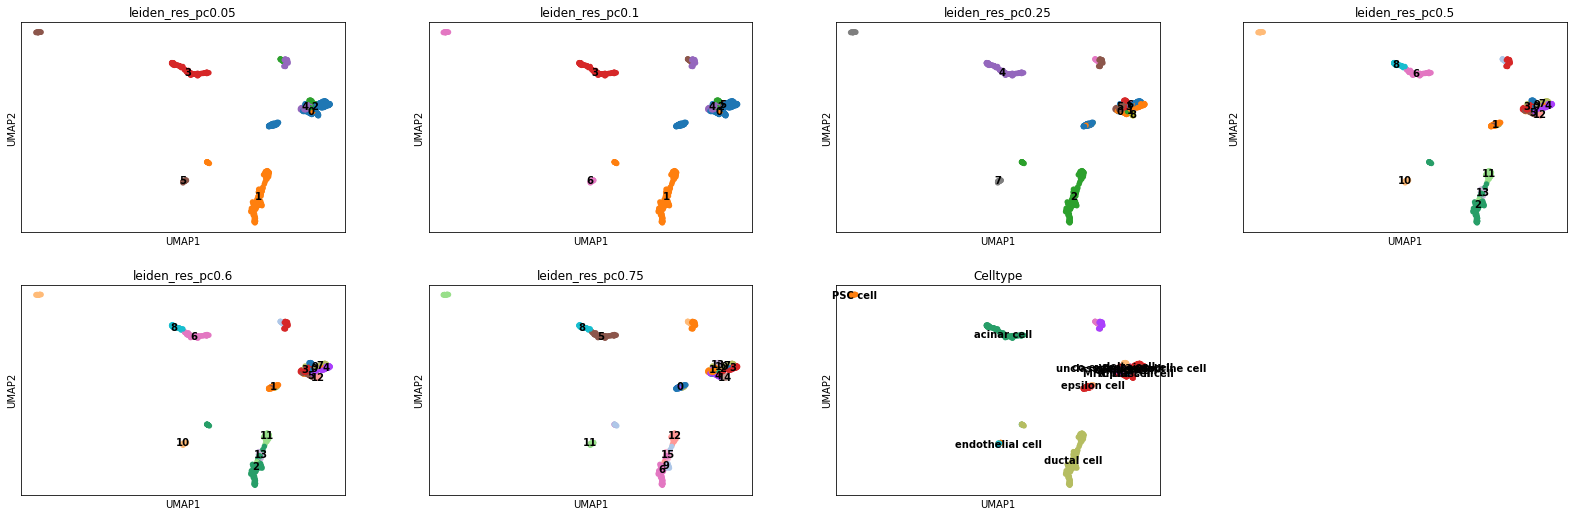

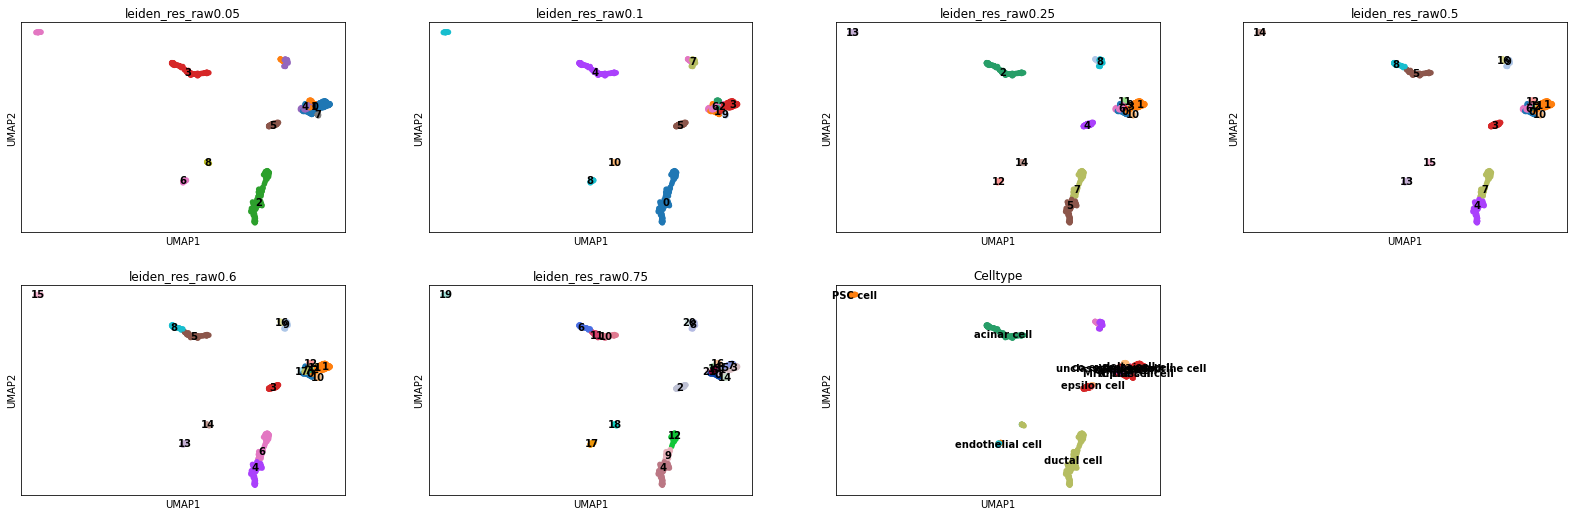

resolution: leiden_res_pc0.05, ARI: 0.9114956680321572, V-measure: 0.8940563508967089, Silhouette score: 0.6320561170578003, Average: 0.8125360453288888
resolution: leiden_res_pc0.1, ARI: 0.9378769433826504, V-measure: 0.9195130624566302, Silhouette score: 0.6647003293037415, Average: 0.8406967783810074
resolution: leiden_res_pc0.25, ARI: 0.6760141824534706, V-measure: 0.8394035368481946, Silhouette score: 0.49112898111343384, Average: 0.6688489001383663
resolution: leiden_res_pc0.5, ARI: 0.4550101336394276, V-measure: 0.751874148227689, Silhouette score: 0.35566890239715576, Average: 0.5208510614214241
resolution: leiden_res_pc0.6, ARI: 0.4550101336394276, V-measure: 0.751874148227689, Silhouette score: 0.35566890239715576, Average: 0.5208510614214241
resolution: leiden_res_pc0.75, ARI: 0.4046215594040079, V-measure: 0.730254177107595, Silhouette score: 0.31882989406585693, Average: 0.48456854352581996
Performing clustering with impute= True, recipe=None, harmony_pca=False


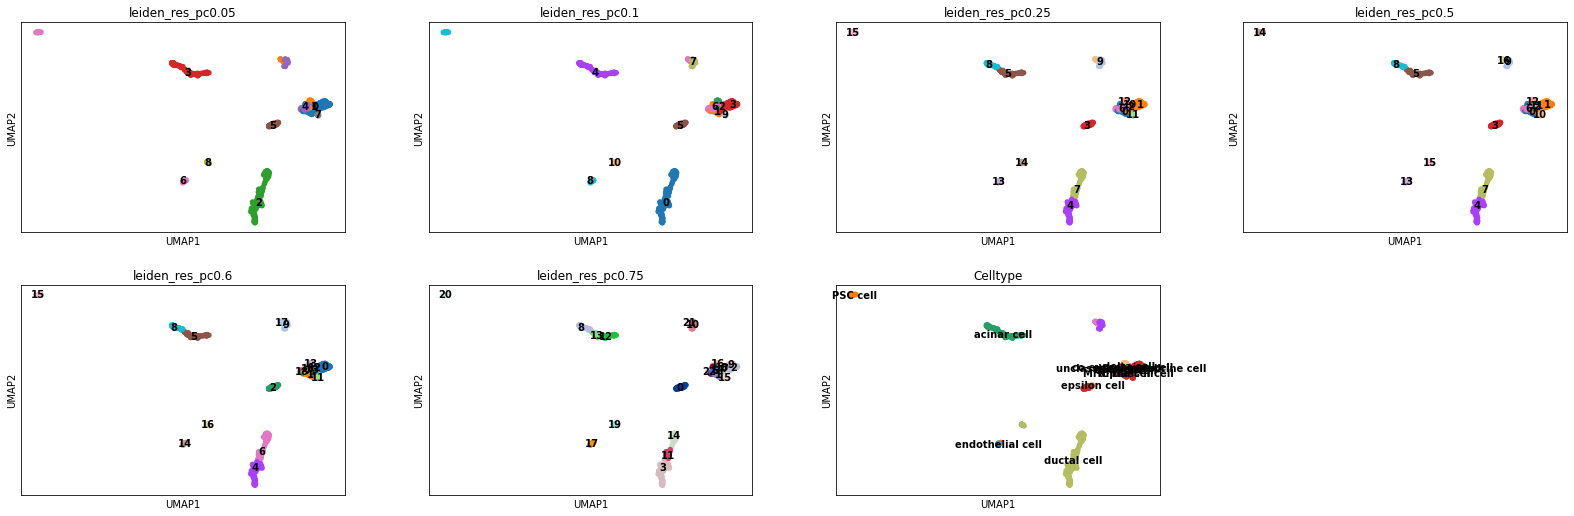

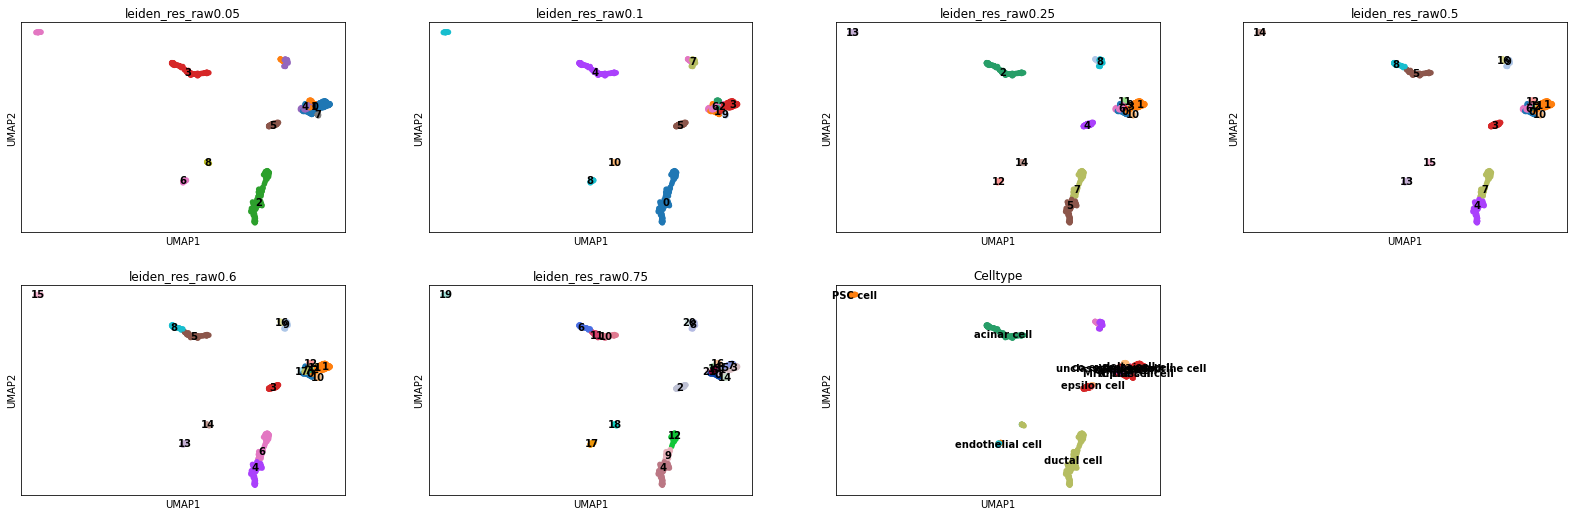

resolution: leiden_res_pc0.05, ARI: 0.6947585272623309, V-measure: 0.814588993193727, Silhouette score: 0.44130900502204895, Average: 0.6502188418260356
resolution: leiden_res_pc0.1, ARI: 0.5506728779500473, V-measure: 0.7704487400193498, Silhouette score: 0.5251448750495911, Average: 0.6154221643396628
resolution: leiden_res_pc0.25, ARI: 0.458188625004566, V-measure: 0.7431732102057342, Silhouette score: 0.5973938703536987, Average: 0.5995852351879997
resolution: leiden_res_pc0.5, ARI: 0.45944375404475474, V-measure: 0.7426325907971467, Silhouette score: 0.5987353920936584, Average: 0.60027057897852
resolution: leiden_res_pc0.6, ARI: 0.4229478804960432, V-measure: 0.7265834196416087, Silhouette score: 0.575415849685669, Average: 0.5749823832744403
resolution: leiden_res_pc0.75, ARI: 0.3165503235461279, V-measure: 0.6824786260633061, Silhouette score: 0.4788222312927246, Average: 0.49261706030071956
Performing clustering with impute= False, recipe=seurat, harmony_pca=True


2023-04-30 23:00:12,428 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-04-30 23:00:12,773 - harmonypy - INFO - sklearn.KMeans initialization complete.


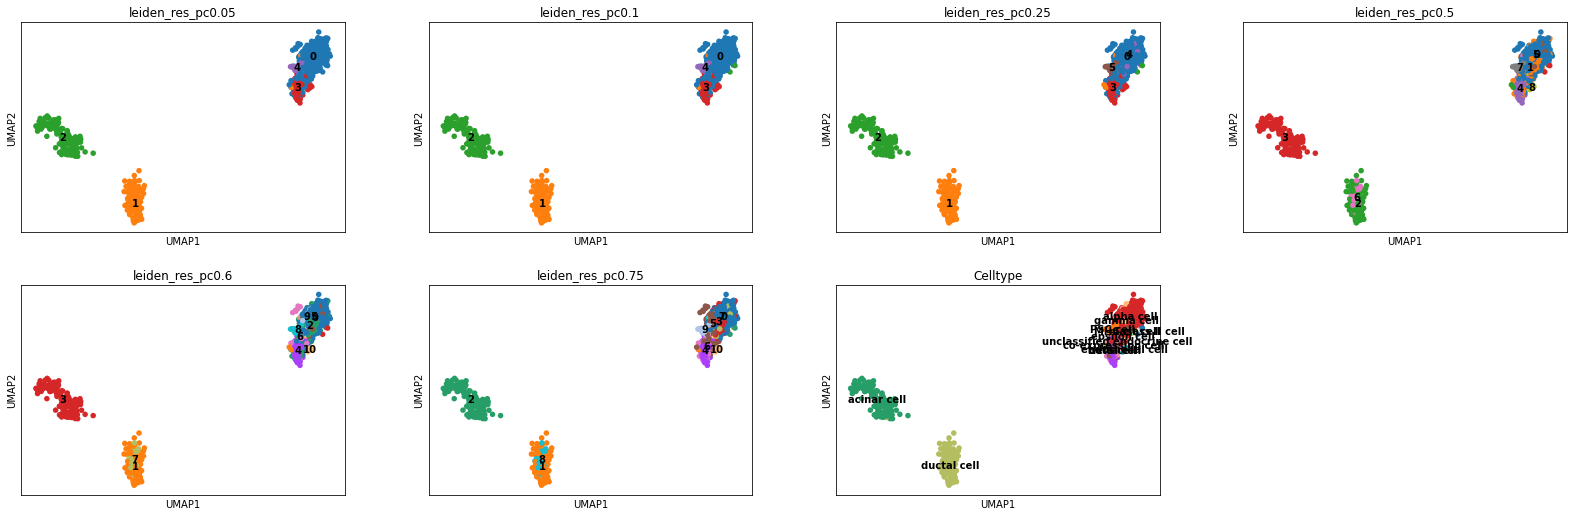

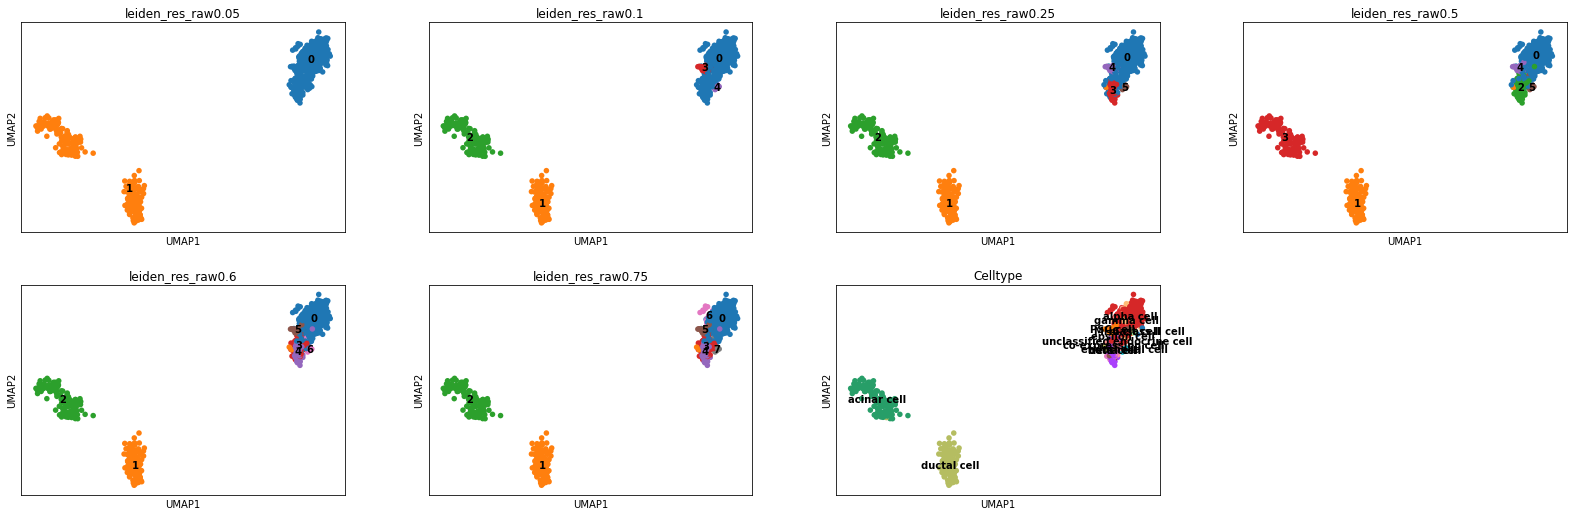

resolution: leiden_res_pc0.05, ARI: 0.5819753286265236, V-measure: 0.7359761200643358, Silhouette score: 0.28921958804130554, Average: 0.5357236789107217
resolution: leiden_res_pc0.1, ARI: 0.585258601311024, V-measure: 0.7373032594512582, Silhouette score: 0.28966188430786133, Average: 0.5374079150233811
resolution: leiden_res_pc0.25, ARI: 0.61585245312423, V-measure: 0.7275490700405566, Silhouette score: 0.22610267996788025, Average: 0.523168067710889
resolution: leiden_res_pc0.5, ARI: 0.7754380050197889, V-measure: 0.7644985990095264, Silhouette score: 0.18225574493408203, Average: 0.5740641163211325
resolution: leiden_res_pc0.6, ARI: 0.7397364000560932, V-measure: 0.7457671033702645, Silhouette score: 0.1810251623392105, Average: 0.5555095552551894
resolution: leiden_res_pc0.75, ARI: 0.6763952327406534, V-measure: 0.7490009123336286, Silhouette score: 0.15287087857723236, Average: 0.5260890078838382
Performing clustering with impute= False, recipe=seurat, harmony_pca=False


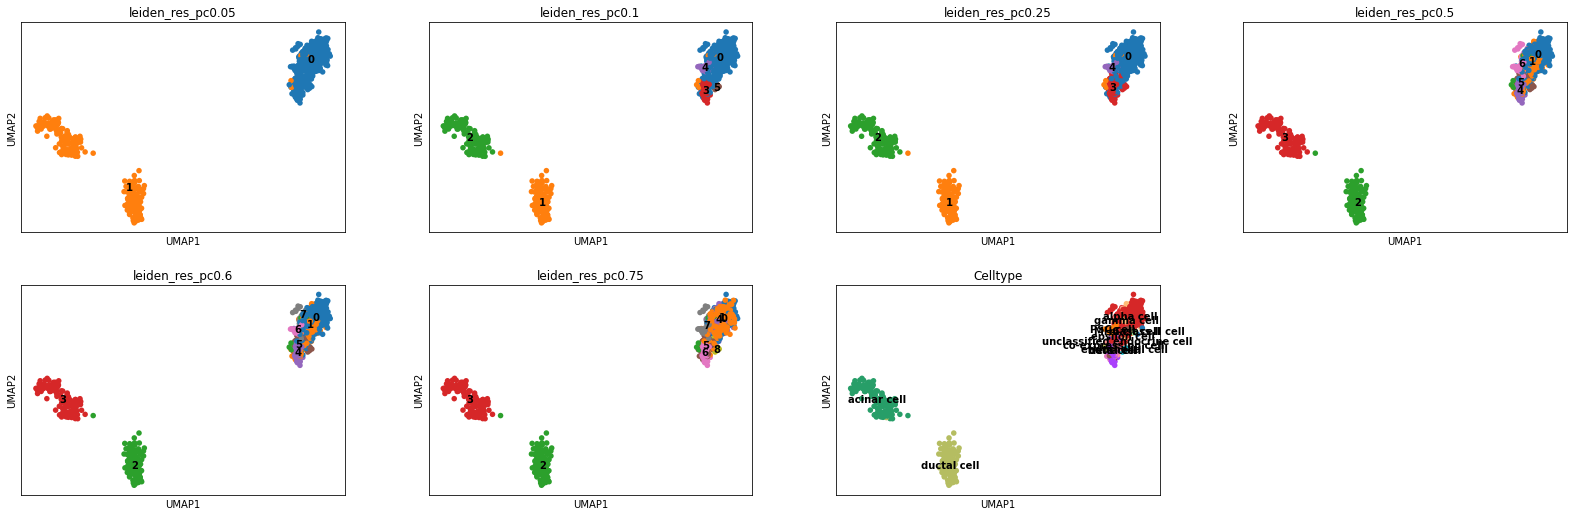

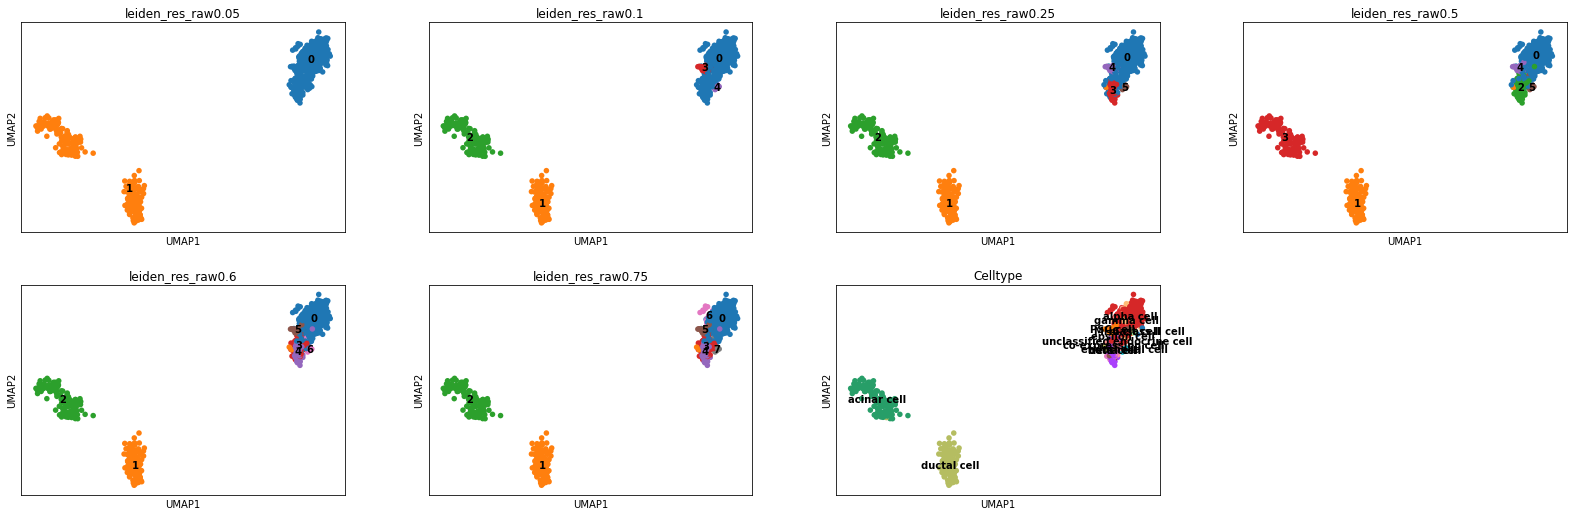

resolution: leiden_res_pc0.05, ARI: 0.31890849658379256, V-measure: 0.4761688794574504, Silhouette score: 0.2906624674797058, Average: 0.3619132811736496
resolution: leiden_res_pc0.1, ARI: 0.5322633512289053, V-measure: 0.7135642010537763, Silhouette score: 0.19140022993087769, Average: 0.47907592740451976
resolution: leiden_res_pc0.25, ARI: 0.6182158824035332, V-measure: 0.7626624579748501, Silhouette score: 0.2591927945613861, Average: 0.5466903783132565
resolution: leiden_res_pc0.5, ARI: 0.7573655416832588, V-measure: 0.7598018714795941, Silhouette score: 0.12090443074703217, Average: 0.5460239479699617
resolution: leiden_res_pc0.6, ARI: 0.7606097245045395, V-measure: 0.7705677113766052, Silhouette score: 0.13497111201286316, Average: 0.5553828492980025
resolution: leiden_res_pc0.75, ARI: 0.5939369385645175, V-measure: 0.7298156551638025, Silhouette score: 0.08722320199012756, Average: 0.47032526523948254
Performing clustering with impute= False, recipe=zheng, harmony_pca=True


2023-04-30 23:00:26,995 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-04-30 23:00:27,214 - harmonypy - INFO - sklearn.KMeans initialization complete.


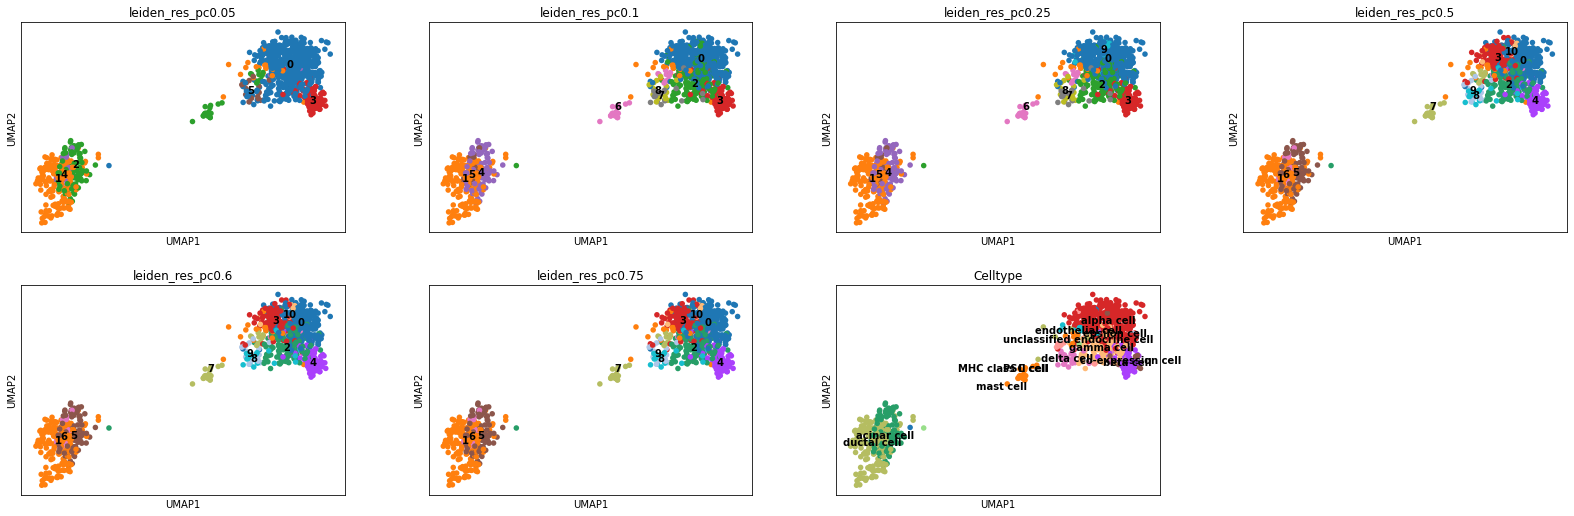

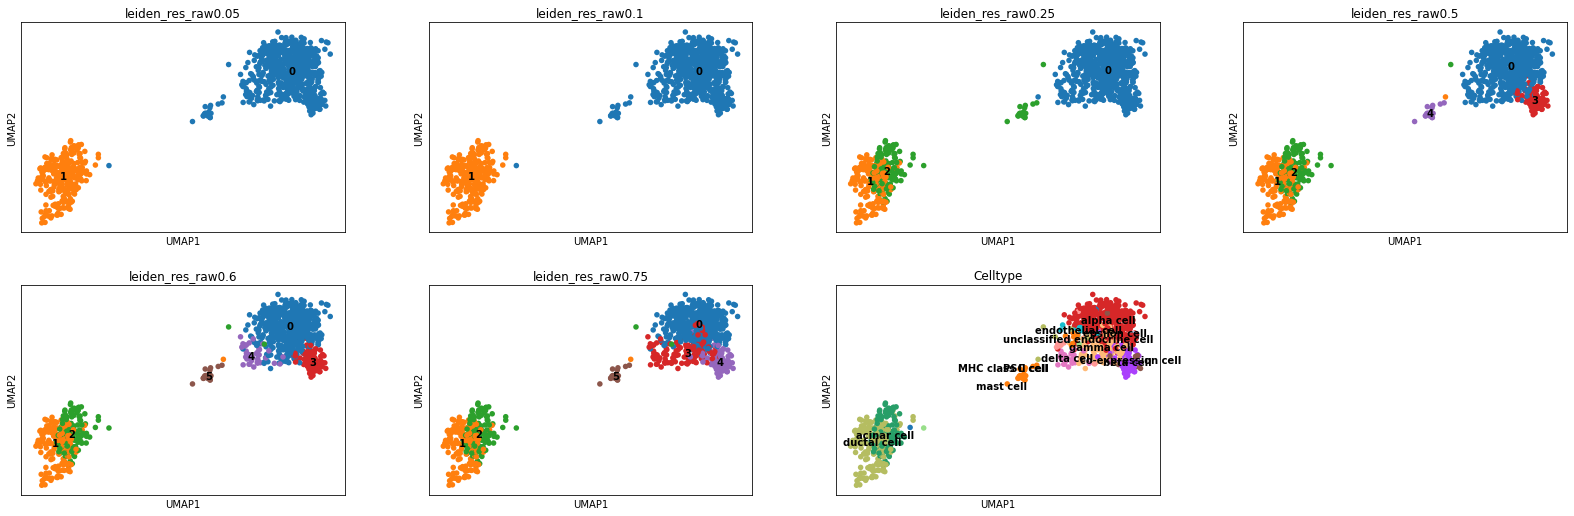

resolution: leiden_res_pc0.05, ARI: 0.6217299747200686, V-measure: 0.7340103351483445, Silhouette score: 0.2833731472492218, Average: 0.546371152372545
resolution: leiden_res_pc0.1, ARI: 0.8878706930529257, V-measure: 0.855209808604966, Silhouette score: 0.31231534481048584, Average: 0.6851319488227925
resolution: leiden_res_pc0.25, ARI: 0.8995711116501034, V-measure: 0.8697318256508156, Silhouette score: 0.3201223909854889, Average: 0.6964751094288028
resolution: leiden_res_pc0.5, ARI: 0.6878155431523937, V-measure: 0.8173794869883133, Silhouette score: 0.20591390132904053, Average: 0.5703696438232492
resolution: leiden_res_pc0.6, ARI: 0.6868461124843854, V-measure: 0.8172301413835288, Silhouette score: 0.2060418426990509, Average: 0.5700393655223217
resolution: leiden_res_pc0.75, ARI: 0.6858921474337727, V-measure: 0.8170835489576975, Silhouette score: 0.2063474804162979, Average: 0.5697743922692561
Performing clustering with impute= False, recipe=zheng, harmony_pca=False


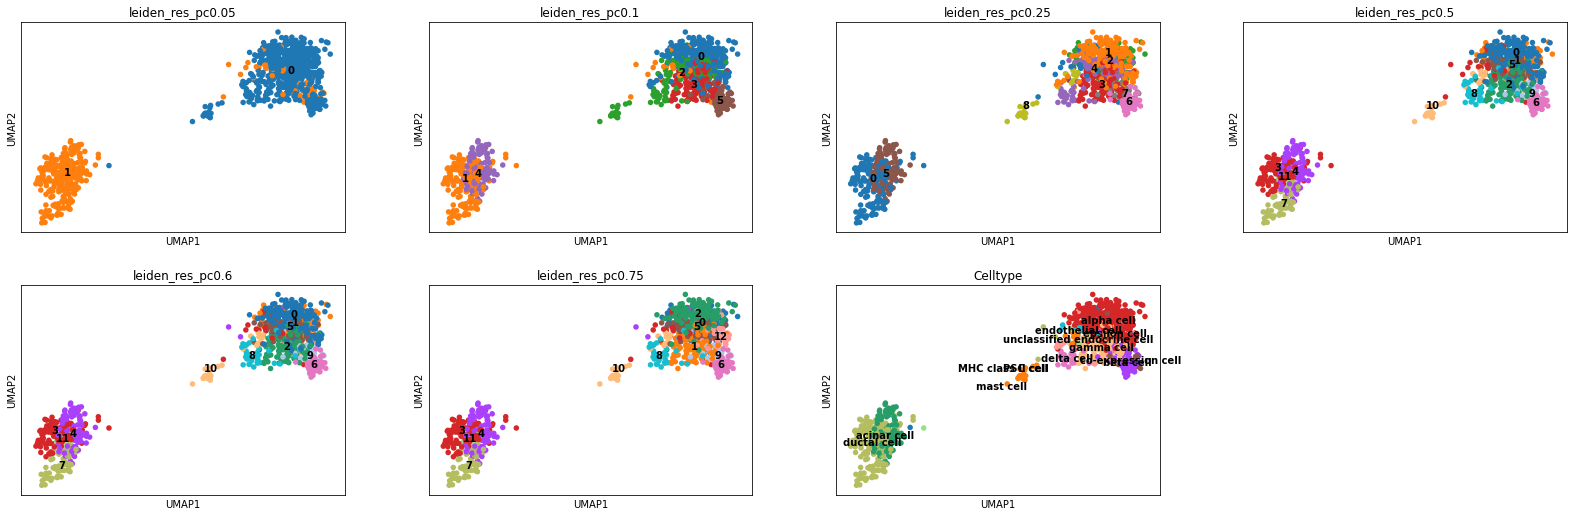

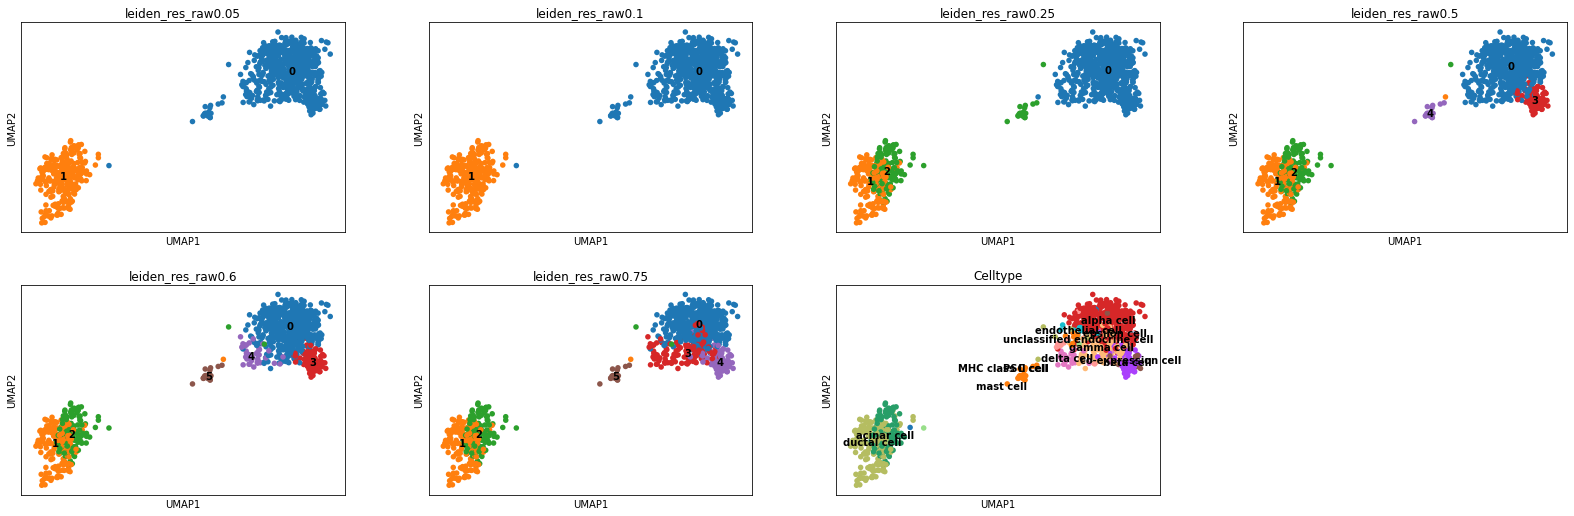

resolution: leiden_res_pc0.05, ARI: 0.35252643870649747, V-measure: 0.4555659942559172, Silhouette score: 0.3038650155067444, Average: 0.370652482823053
resolution: leiden_res_pc0.1, ARI: 0.7310858106066553, V-measure: 0.8112036365238963, Silhouette score: 0.19796313345432281, Average: 0.5800841935282914
resolution: leiden_res_pc0.25, ARI: 0.5776243441255804, V-measure: 0.7734995549432595, Silhouette score: 0.15249139070510864, Average: 0.5012050965913162
resolution: leiden_res_pc0.5, ARI: 0.5252338843224575, V-measure: 0.7664539654042236, Silhouette score: 0.1362152397632599, Average: 0.475967696496647
resolution: leiden_res_pc0.6, ARI: 0.522700748917036, V-measure: 0.7635778777979266, Silhouette score: 0.13373412191867828, Average: 0.4733375828778803
resolution: leiden_res_pc0.75, ARI: 0.49206556265633605, V-measure: 0.7510589957790949, Silhouette score: 0.11016303300857544, Average: 0.45109586381466876
Performing clustering with impute= False, recipe=weinreb, harmony_pca=True


2023-04-30 23:00:43,797 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-04-30 23:00:44,231 - harmonypy - INFO - sklearn.KMeans initialization complete.


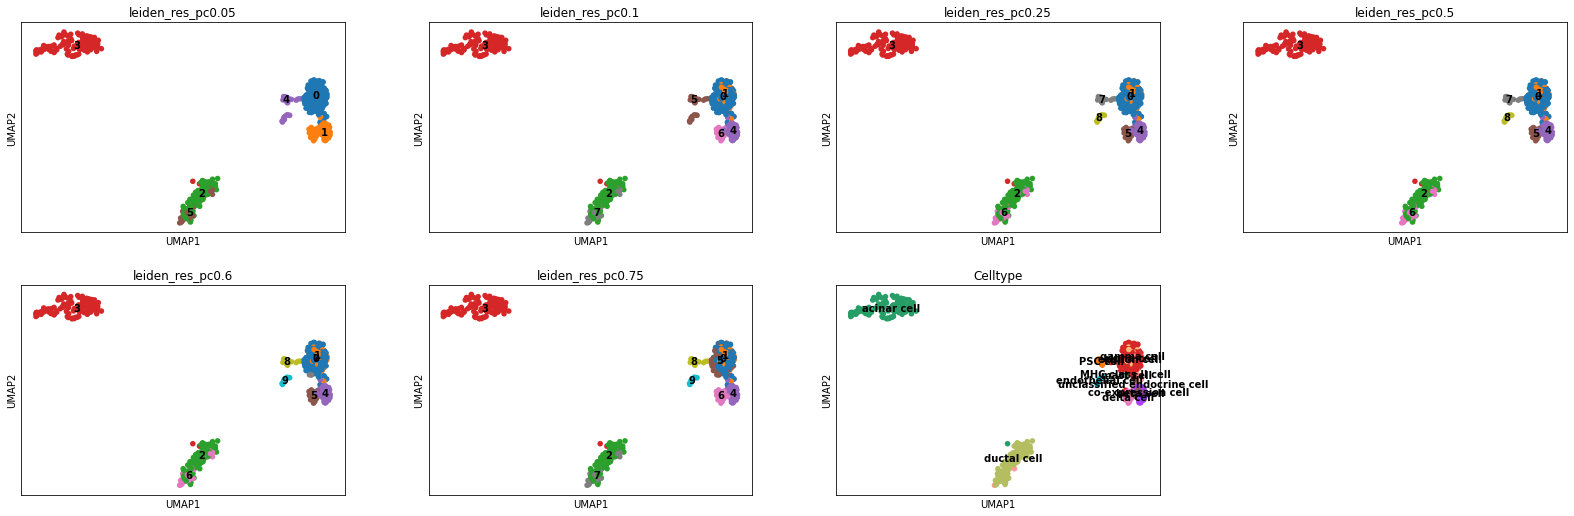

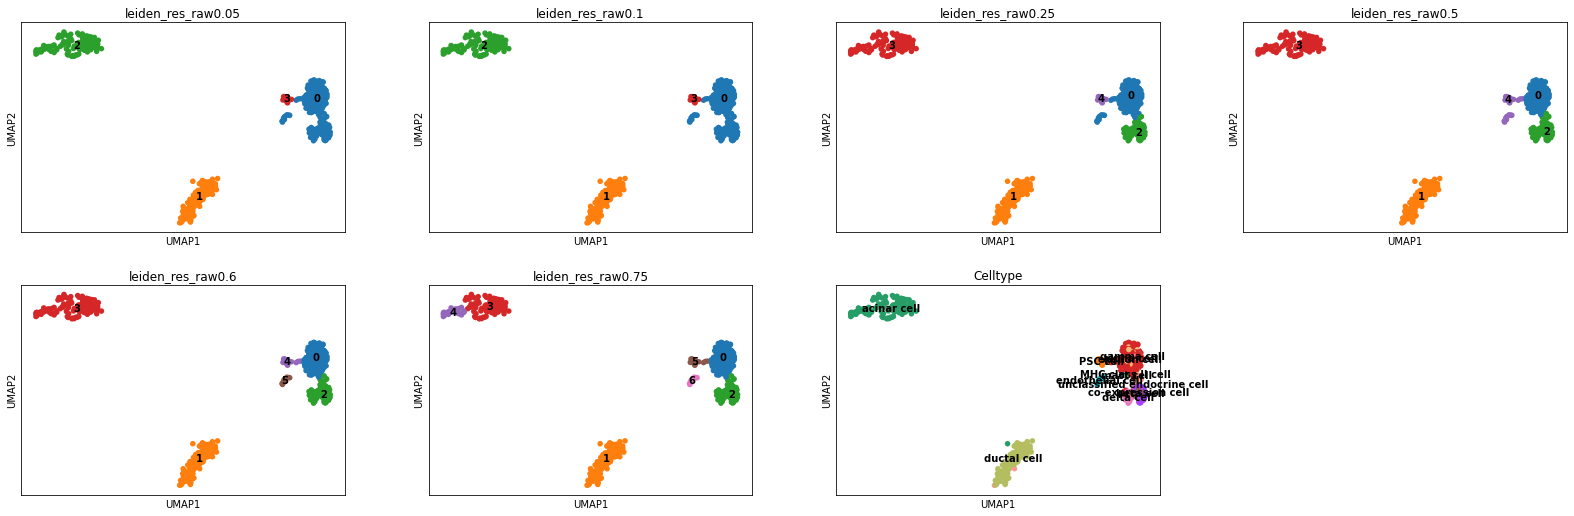

resolution: leiden_res_pc0.05, ARI: 0.6454248786379426, V-measure: 0.7702508178854909, Silhouette score: 0.3855232000350952, Average: 0.6003996321861762
resolution: leiden_res_pc0.1, ARI: 0.901877189214508, V-measure: 0.8877654180493337, Silhouette score: 0.3000852167606354, Average: 0.6965759413414924
resolution: leiden_res_pc0.25, ARI: 0.8989478615563188, V-measure: 0.8935001327641132, Silhouette score: 0.305797278881073, Average: 0.6994150910671683
resolution: leiden_res_pc0.5, ARI: 0.9064316447008586, V-measure: 0.8981576269192684, Silhouette score: 0.3096731901168823, Average: 0.7047541539123364
resolution: leiden_res_pc0.6, ARI: 0.8693289390014901, V-measure: 0.8777501323390153, Silhouette score: 0.32885274291038513, Average: 0.6919772714169635
resolution: leiden_res_pc0.75, ARI: 0.747505791048396, V-measure: 0.8431979954215084, Silhouette score: 0.26382875442504883, Average: 0.6181775136316511
Performing clustering with impute= False, recipe=weinreb, harmony_pca=False


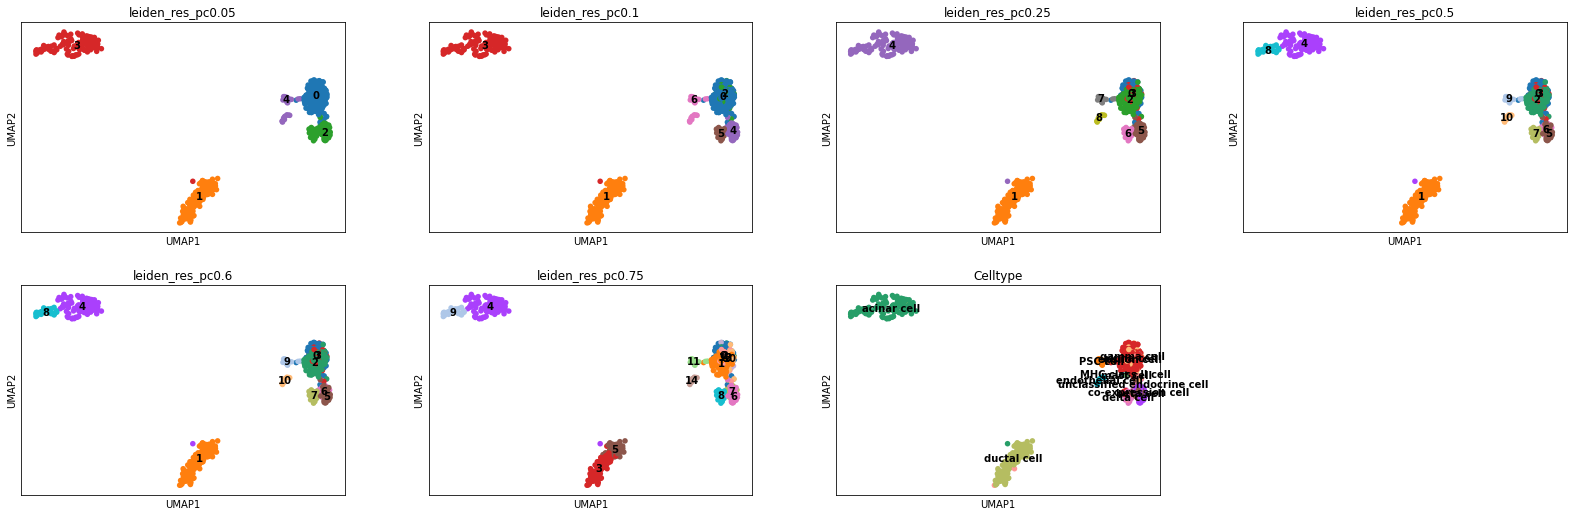

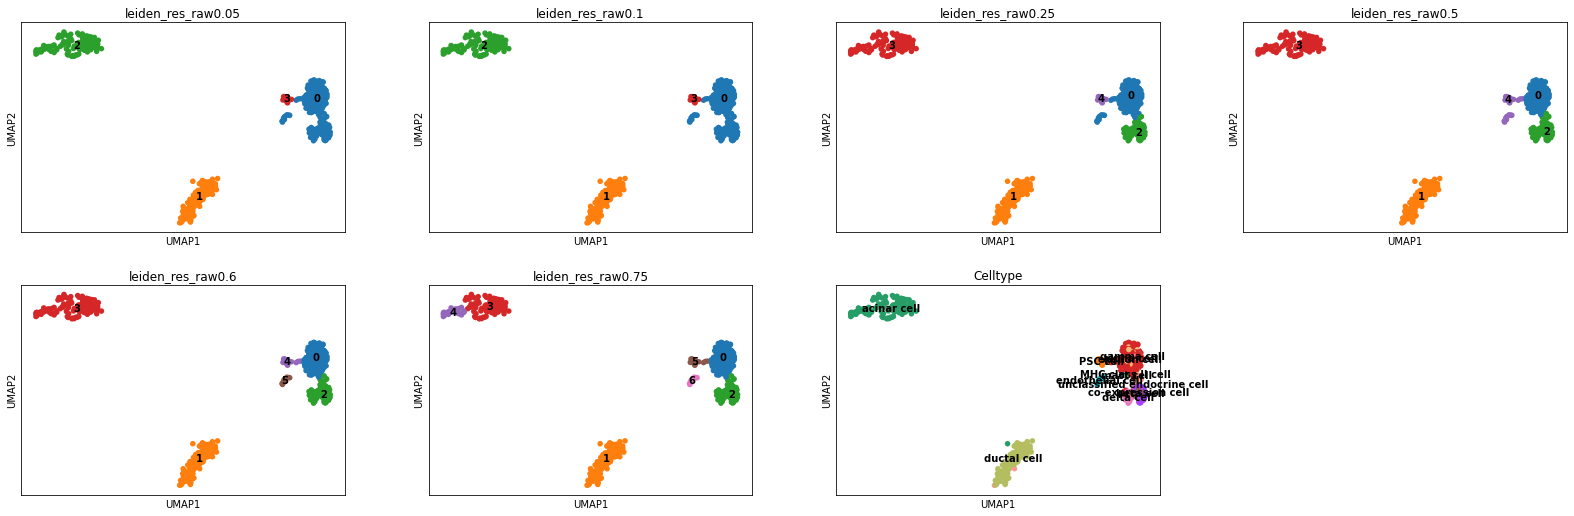

resolution: leiden_res_pc0.05, ARI: 0.6753446929539305, V-measure: 0.7975838799445224, Silhouette score: 0.3459361493587494, Average: 0.6062882407524007
resolution: leiden_res_pc0.1, ARI: 0.9326047868764481, V-measure: 0.9159887807579278, Silhouette score: 0.2471000999212265, Average: 0.6985645558518675
resolution: leiden_res_pc0.25, ARI: 0.7164601979471767, V-measure: 0.8614095290147903, Silhouette score: 0.1817934662103653, Average: 0.5865543977241108
resolution: leiden_res_pc0.5, ARI: 0.6834081841170815, V-measure: 0.8308811100307814, Silhouette score: 0.19860951602458954, Average: 0.5709662700574841
resolution: leiden_res_pc0.6, ARI: 0.6834081841170815, V-measure: 0.8308811100307814, Silhouette score: 0.19860951602458954, Average: 0.5709662700574841
resolution: leiden_res_pc0.75, ARI: 0.5437732288046925, V-measure: 0.7694428813047003, Silhouette score: 0.1093747690320015, Average: 0.4741969597137981
Performing clustering with impute= False, recipe=basic, harmony_pca=True


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
2023-04-30 23:01:02,860 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-04-30 23:01:03,316 - harmonypy - INFO - sklearn.KMeans initialization complete.


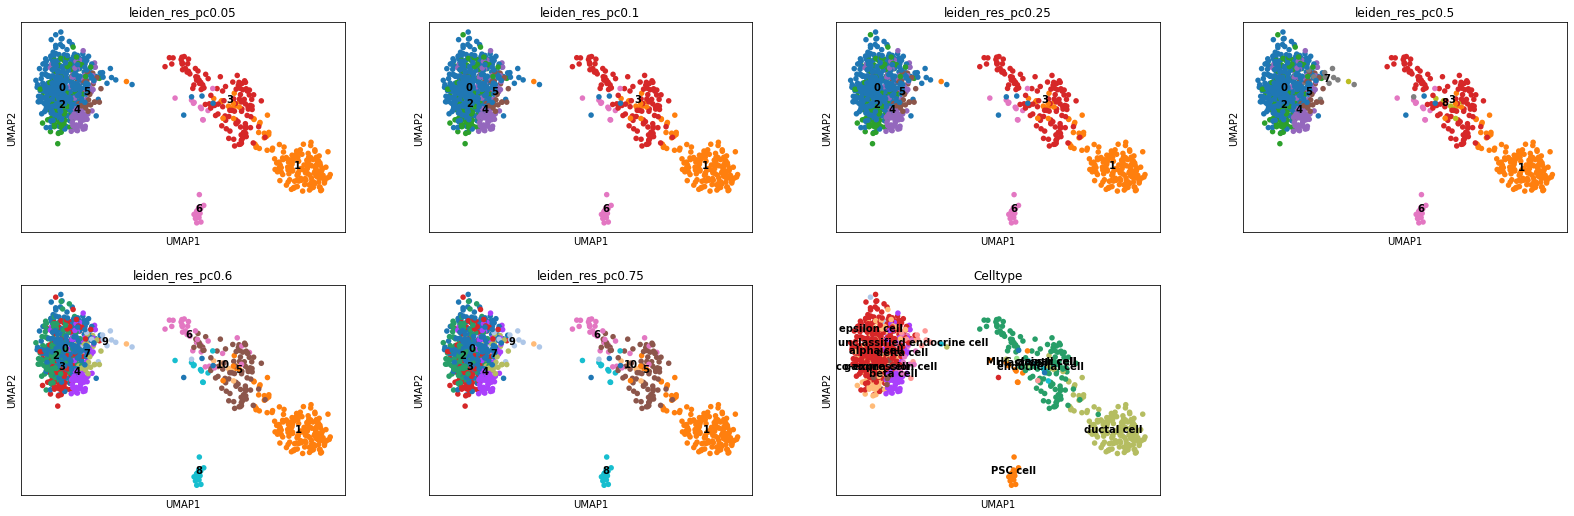

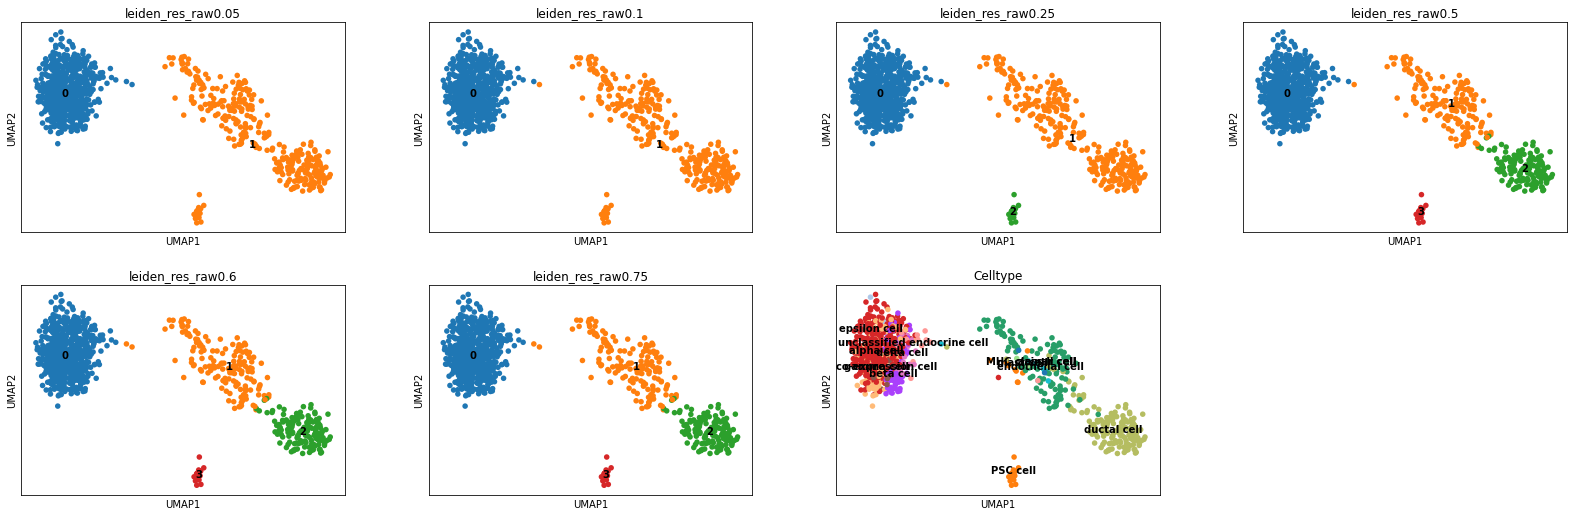

resolution: leiden_res_pc0.05, ARI: 0.9110321985169436, V-measure: 0.9048254699784999, Silhouette score: 0.27034616470336914, Average: 0.6954012777329375
resolution: leiden_res_pc0.1, ARI: 0.9202463139224312, V-measure: 0.9062272947132297, Silhouette score: 0.2712812125682831, Average: 0.6992516070679814
resolution: leiden_res_pc0.25, ARI: 0.9202468377204444, V-measure: 0.9062832986006023, Silhouette score: 0.27116256952285767, Average: 0.6992309019479682
resolution: leiden_res_pc0.5, ARI: 0.9566651831061777, V-measure: 0.9318207165103496, Silhouette score: 0.29490670561790466, Average: 0.7277975350781439
resolution: leiden_res_pc0.6, ARI: 0.7144461235746522, V-measure: 0.8551840437533625, Silhouette score: 0.16647814214229584, Average: 0.5787027698234368
resolution: leiden_res_pc0.75, ARI: 0.7119438345494228, V-measure: 0.8548062152831989, Silhouette score: 0.1664351522922516, Average: 0.5777284007082911
Performing clustering with impute= False, recipe=basic, harmony_pca=False


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


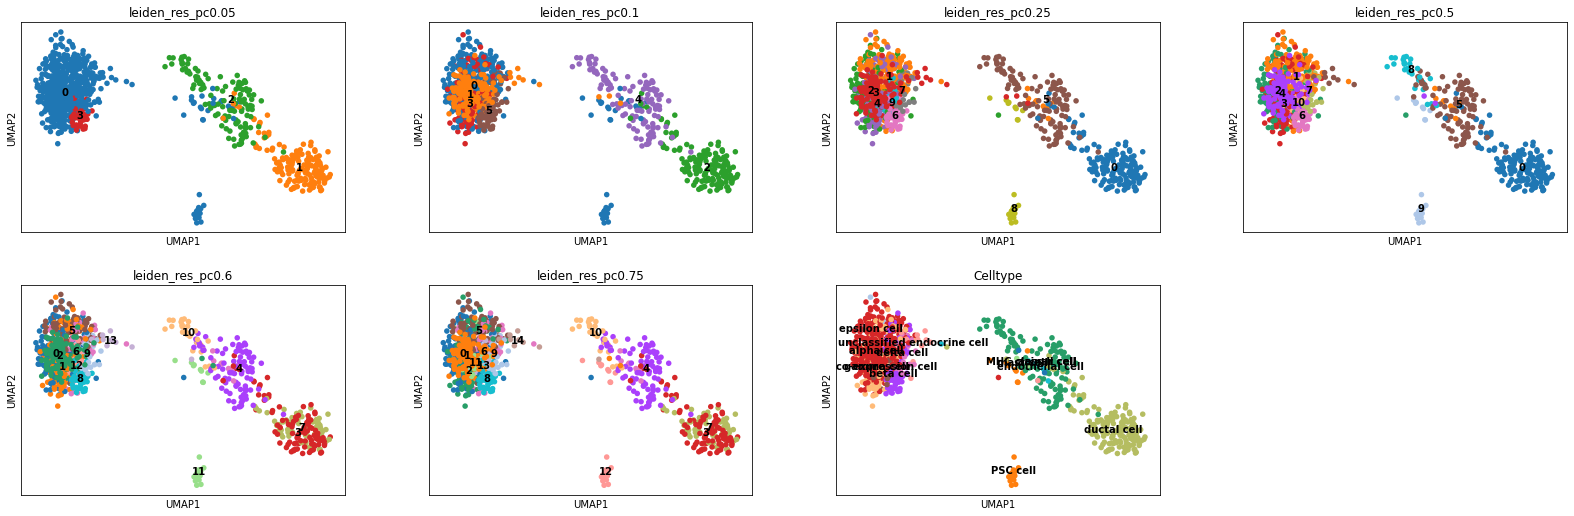

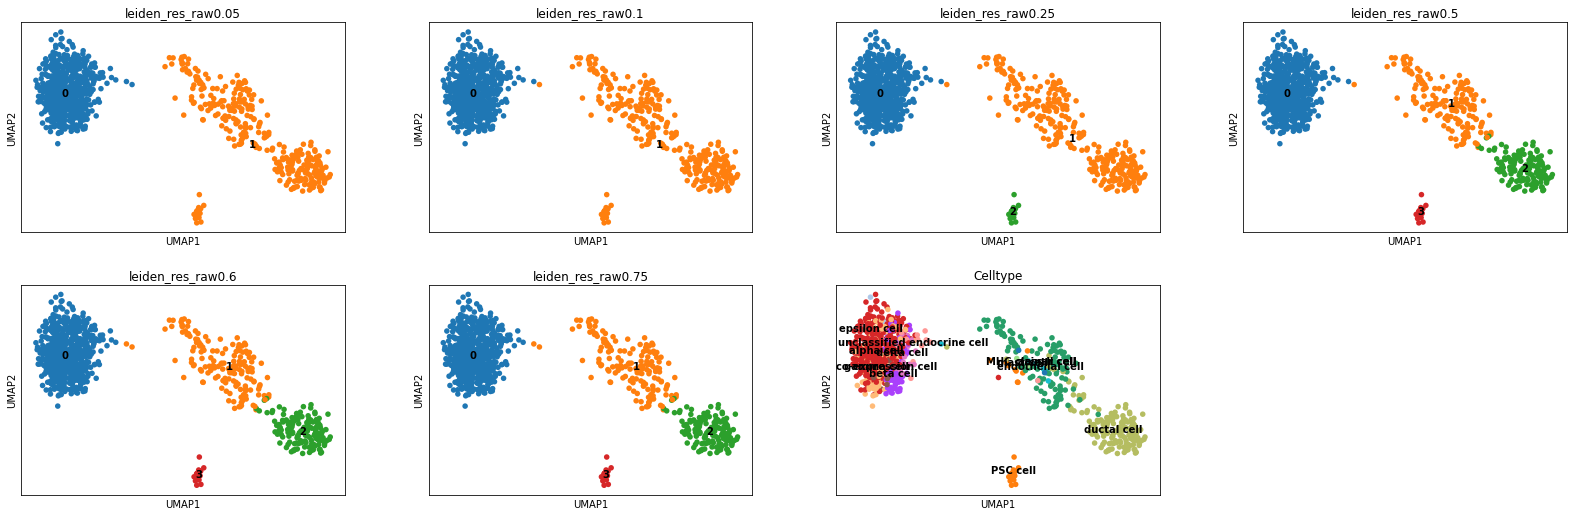

resolution: leiden_res_pc0.05, ARI: 0.44098263959411715, V-measure: 0.6298007583422591, Silhouette score: 0.18197059631347656, Average: 0.417584664749951
resolution: leiden_res_pc0.1, ARI: 0.5749265693641136, V-measure: 0.739967530920955, Silhouette score: 0.11363569647073746, Average: 0.476176598918602
resolution: leiden_res_pc0.25, ARI: 0.5438003916253599, V-measure: 0.7571468393927522, Silhouette score: 0.12186653167009354, Average: 0.47427125422940186
resolution: leiden_res_pc0.5, ARI: 0.5199807096326795, V-measure: 0.7446946179751436, Silhouette score: 0.10444524139165878, Average: 0.4563735229998273
resolution: leiden_res_pc0.6, ARI: 0.5010409794633243, V-measure: 0.7651164111857637, Silhouette score: 0.12100179493427277, Average: 0.46238639519445357
resolution: leiden_res_pc0.75, ARI: 0.4800291401201797, V-measure: 0.7549300865482784, Silhouette score: 0.12320880591869354, Average: 0.45272267752905054
Performing clustering with impute= False, recipe=None, harmony_pca=True


2023-04-30 23:01:20,949 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-04-30 23:01:21,606 - harmonypy - INFO - sklearn.KMeans initialization complete.


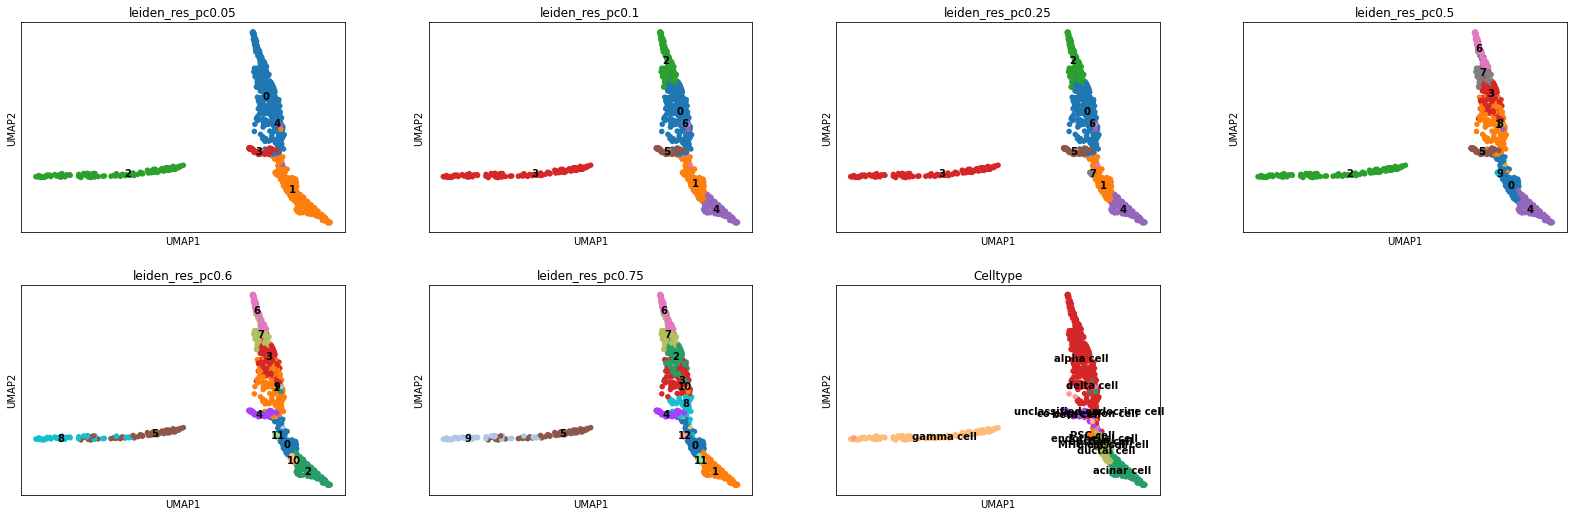

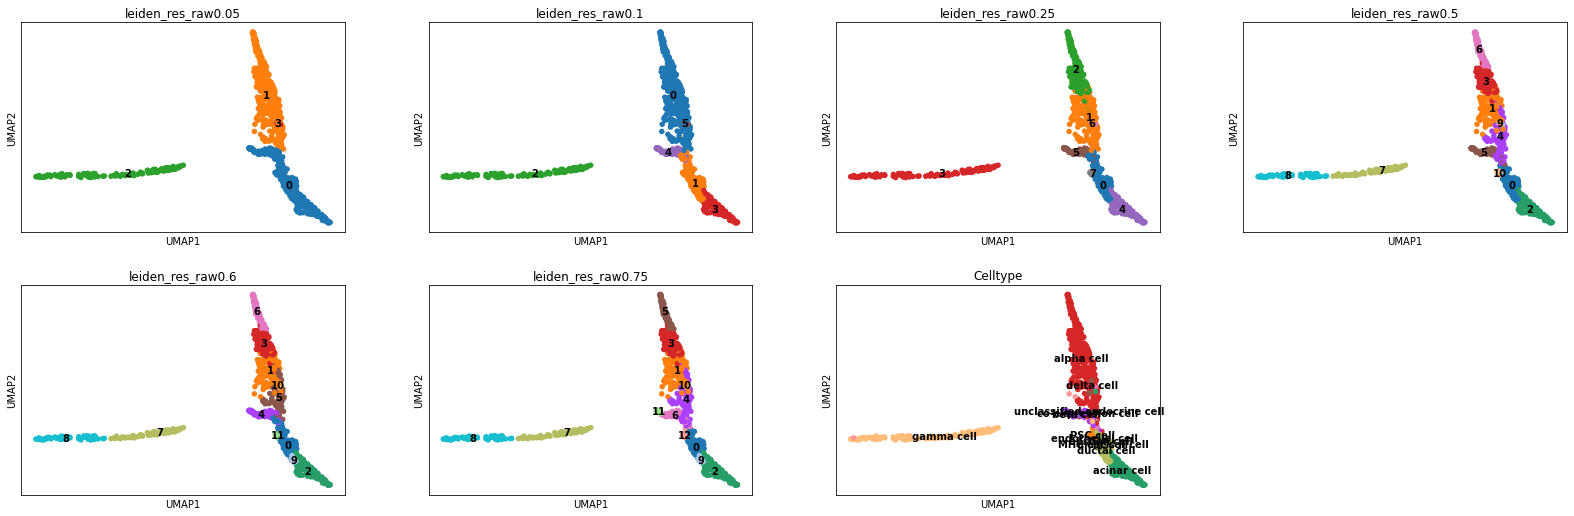

resolution: leiden_res_pc0.05, ARI: 0.7253942631650316, V-measure: 0.7541090717568709, Silhouette score: 0.4226852357387543, Average: 0.6340628568868856
resolution: leiden_res_pc0.1, ARI: 0.6277974619297967, V-measure: 0.7577005200590898, Silhouette score: 0.44665253162384033, Average: 0.610716837870909
resolution: leiden_res_pc0.25, ARI: 0.6512293084071714, V-measure: 0.7753055922851729, Silhouette score: 0.33251431584358215, Average: 0.5863497388453088
resolution: leiden_res_pc0.5, ARI: 0.5019356290642606, V-measure: 0.7253581648590685, Silhouette score: 0.2944413423538208, Average: 0.5072450454257166
resolution: leiden_res_pc0.6, ARI: 0.45432637635435813, V-measure: 0.7118637048687954, Silhouette score: 0.2743396759033203, Average: 0.48017658570882454
resolution: leiden_res_pc0.75, ARI: 0.41810717661260244, V-measure: 0.6991672533511115, Silhouette score: 0.27404454350471497, Average: 0.463772991156143
Performing clustering with impute= False, recipe=None, harmony_pca=False


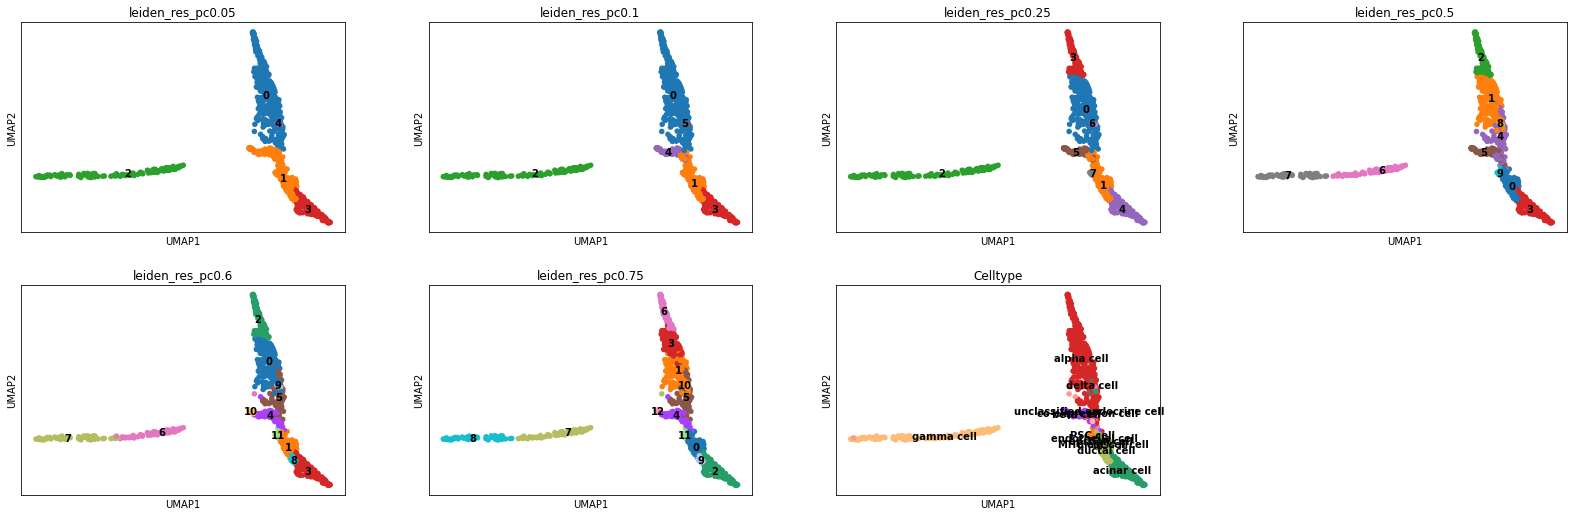

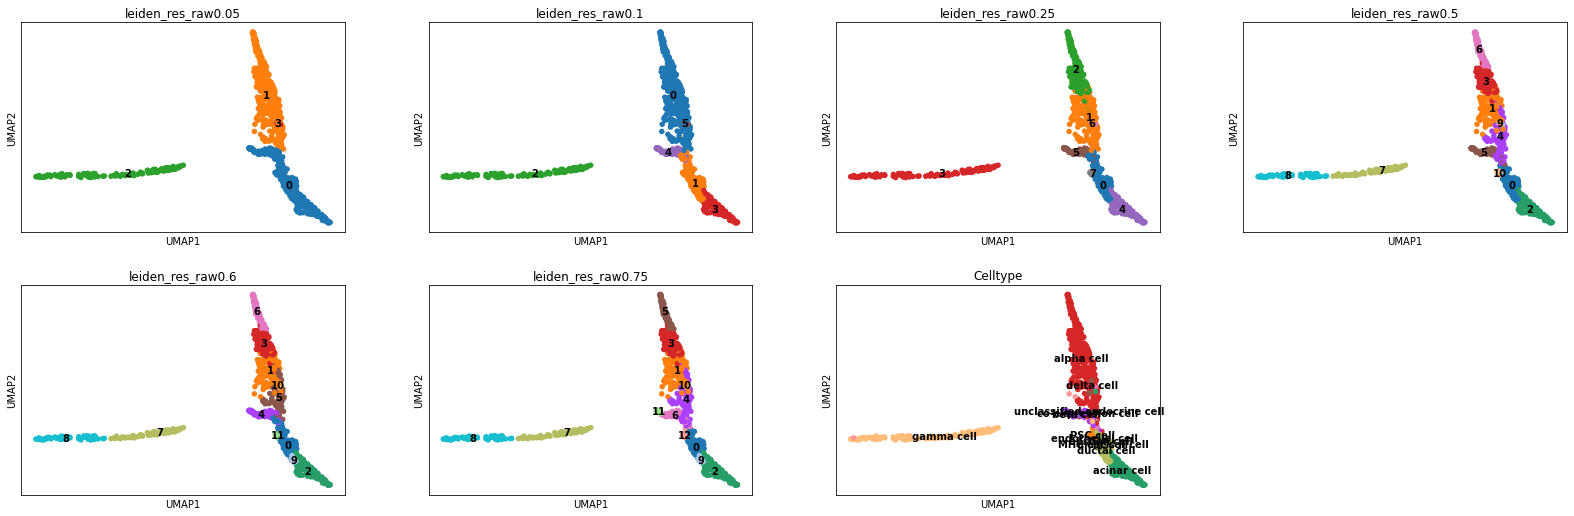

resolution: leiden_res_pc0.05, ARI: 0.7531397099740464, V-measure: 0.7797771733059266, Silhouette score: 0.39037978649139404, Average: 0.6410988899237889
resolution: leiden_res_pc0.1, ARI: 0.855800875352281, V-measure: 0.8324741570649525, Silhouette score: 0.3678878843784332, Average: 0.6853876389318888
resolution: leiden_res_pc0.25, ARI: 0.6830547773042673, V-measure: 0.7958048656822425, Silhouette score: 0.28569307923316956, Average: 0.5881842407398931
resolution: leiden_res_pc0.5, ARI: 0.5677850828975672, V-measure: 0.7706529949630178, Silhouette score: 0.2885458171367645, Average: 0.5423279649991165
resolution: leiden_res_pc0.6, ARI: 0.5285848934016619, V-measure: 0.7518734940011367, Silhouette score: 0.29986727237701416, Average: 0.5267752199266043
resolution: leiden_res_pc0.75, ARI: 0.4599468223220397, V-measure: 0.7310761753849211, Silhouette score: 0.26782047748565674, Average: 0.4862811583975392


In [90]:
# Adjust these lists according to the parameters you want to test
imputed = [True, False]
recipe_list = ['seurat', 'zheng', 'weinreb', 'basic', 'None']
harmony_pca_list = [True, False]
leiden_resolution_list = [0.05, 0.1, 0.25, 0.5, 0.6, 0.75]
cluster_leiden = [True, False]
umap = True

results = []
maxavg = 0
maxsil = 0

# create sc_pancreas_metadata_test_fake that includes "test cell type" as a column
sc_pancreas_metadata_test_fake = sc_pancreas_metadata_test.copy()
sc_pancreas_metadata_test_fake['Celltype'] = sc_pancreas_metadata_test_fake['Disease']

# trainsamp = pd.DataFrame(sc_pancreas_metadata[['Sample', 'Disease']], index= sc_pancreas_metadata.index)
# testsamp = pd.DataFrame(sc_pancreas_metadata_test[['Sample', 'Disease']], index= sc_pancreas_metadata_test.index)
metadata_all = pd.concat([sc_pancreas_metadata, sc_pancreas_metadata_test_fake], axis=0)

# Iterate over all combinations of parameters and perform clustering
# adata is of all cells not just train
for impute in imputed:
    if impute:
        adata = sc.AnnData(sc_pancreas_cutoff_norm_imp.T)
    else:
        adata = sc.AnnData(sc_pancreas.T)
    for recipe in recipe_list:
        for harmony_pca in harmony_pca_list:
                print(f'Performing clustering with impute= {impute}, recipe={recipe}, harmony_pca={harmony_pca}')
                
                adata_result = perform_clustering(adata, use_recipe=recipe,
                                            use_harmony_pca=harmony_pca, leiden_resolution=leiden_resolution_list,
                                            sc_pancreas_metadata= sc_pancreas_metadata, imputed = impute)
                result = {
                    'adata': adata_result,
                    'seurat_recipe': recipe,
                    'harmony_pca': harmony_pca
                }
                results.append(result)

                if umap:
                    sc.pl.umap(
                    adata_result,
                    color=[ "leiden_res_pc0.05", "leiden_res_pc0.1", "leiden_res_pc0.25", "leiden_res_pc0.5", "leiden_res_pc0.6", "leiden_res_pc0.75",
                           "Celltype"],
                    legend_loc="on data",
                    )

                    sc.pl.umap(
                    adata_result,
                    color=["leiden_res_raw0.05", "leiden_res_raw0.1", "leiden_res_raw0.25", "leiden_res_raw0.5", "leiden_res_raw0.6", "leiden_res_raw0.75",
                           "Celltype"],
                    legend_loc="on data",
                    )

                # calculate scores for each leiden resolution
                for lr in leiden_resolution_list:
                    leiden_key = 'leiden_res_pc' + str(lr)
                    vANDari, silhouette = cluster_scoring(adata_result, leiden_key, sc_pancreas_metadata)
                    # leiden_key_raw = 'leiden_res_raw' + str(lr)
                    # vANDari, silhouette = cluster_scoring(adata_result, leiden_key_raw, sc_pancreas_metadata)

                    if vANDari > maxavg:
                        maxavg = vANDari
                        maximputed = impute
                        maxadata = adata_result
                        maxrecipe = recipe
                        maxharmony_pca = harmony_pca
                        maxleiden_key = lr
                    if silhouette > maxsil:
                        maxsil = silhouette
                        silimputed = impute
                        siladata = adata_result
                        silrecipe = recipe
                        silharmony_pca = harmony_pca
                        silleiden_key = lr

# `results` will now contain the clustering results for all combinations of methods


# Step 3: Predict on the test data

Performing imputation to create imputed_bulkified.csv

In [70]:
# using method 3 to impute
sc_pancreas_test_cutoff = scprep.filter.filter_library_size(sc_pancreas_test,
                                                            cutoff= 1500)
# store removed genes
filteredgenes_test = set(sc_pancreas_test.index) - set(sc_pancreas_test_cutoff.index)

sc_pancreas_test_cutoff_norm = scprep.normalize.library_size_normalize(sc_pancreas_test_cutoff)
sc_pancreas_test_cutoff_norm = scprep.transform.sqrt(sc_pancreas_test_cutoff_norm)

sc_pancreas_test_cutoff_norm_imp = magic_operator.fit_transform(sc_pancreas_test_cutoff_norm.T).T

for gene in filteredgenes_test:
    sc_pancreas_test_cutoff_norm_imp.loc[gene] = [0] * len(sc_pancreas_test_cutoff_norm_imp.columns)

sc_pancreas_test_cutoff_norm_imp = sc_pancreas_test_cutoff_norm_imp.loc[sc_pancreas_test.index, :]

Calculating MAGIC...
  Running MAGIC on 789 cells and 10855 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 3.68 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.07 seconds.
    Calculating affinities...
    Calculated affinities in 0.07 seconds.
  Calculated graph and diffusion operator in 3.88 seconds.
  Running MAGIC with `solver='exact'` on 10855-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.
  Calculating imputation...
  Calculated imputation in 0.24 seconds.
Calculated MAGIC in 4.19 seconds.


In [97]:
bulkified = bulkification(sc_pancreas_test_cutoff_norm_imp)
# bulkified should be a DataFrame containing the "bulkified" version of the imputed data
# turn index into column
bulkified.reset_index(level=0, inplace=True)

bulkified.columns = ["index", "patient5","patient6","patient7"]

### Perform clustering to assign cell cluster membership 

In [98]:
if maximputed:
    adata_test = sc.AnnData(sc_pancreas_test_cutoff_norm_imp.T)
else:
    adata_test = sc.AnnData(sc_pancreas_test.T)

adata_test_cluster = perform_clustering(adata_test, sc_pancreas_metadata_test, use_recipe= maxrecipe, 
                                        use_harmony_pca= maxharmony_pca, leiden_resolution=maxleiden_key,
                                        imputed= maximputed)
maxleiden_key_str = 'leiden_res_pc' + str(maxleiden_key)
cluster_labels = adata_test_cluster.obs[maxleiden_key_str]
cluster_labels = cluster_labels.loc[sc_pancreas_test.columns]

cluster_labels = pd.DataFrame(cluster_labels)
cluster_labels.reset_index(level=0, inplace=True)

2023-04-30 23:08:38,337 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-04-30 23:08:38,850 - harmonypy - INFO - sklearn.KMeans initialization complete.


### Perform PCA to coordinates of the cells in the test dataset in the 50 first PCs computed on your data

In [99]:
if silimputed:
    adata_test_sil = sc.AnnData(sc_pancreas_test_cutoff_norm_imp.T)
else:
    adata_test_sil = sc.AnnData(sc_pancreas_test.T)

adata_test_sil = perform_clustering(adata_test_sil, sc_pancreas_metadata_test, use_recipe= silrecipe,
                                    use_harmony_pca= silharmony_pca, leiden_resolution=silleiden_key,
                                    imputed= silimputed)
PCA = adata_test_sil.obsm['X_pca']
PCA = pd.DataFrame(PCA)
PCA.reset_index(level=0, inplace=True)

# rename columns to be index, PC1, PC2, ... PC50
PCA.columns = ["index"] + ["PC"+str(i+1) for i in range(50)]
PCA["index"] = sc_pancreas_test.columns

2023-04-30 23:08:46,017 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-04-30 23:08:46,146 - harmonypy - INFO - sklearn.KMeans initialization complete.


# Step 4: Save the required files

In [100]:
results_path = os.getcwd()
archive_name = "Jung_HuiJeong_Project2-trial.zip" 

In [101]:
assert all(bulkified.columns == ["index","patient5","patient6","patient7"])

In [102]:
assert all(bulkified["index"] == sc_pancreas_test.index)

In [103]:
# cluster_labels should be a DataFrame containing the cluster labels for each cell
cluster_labels.columns = ["index", "cluster"]
cluster_labels["index"] = sc_pancreas_test.columns

In [104]:
assert all(cluster_labels.columns == ["index","cluster"])

In [105]:
assert all(cluster_labels["index"] == sc_pancreas_test.columns)

In [ ]:
# PCA should be a DataFrame containing the coordinates of each cell in the PCA transformed space for the 50 first PCs
# PCA.columns = ["index", "PC1", "PC2", ..., "PC50"]
# PCA["index"] = sc_pancreas_test.columns

In [106]:
assert all(PCA.columns == ["index"] + ["PC"+str(i+1) for i in range(50)])

In [107]:
assert all(PCA["index"] == sc_pancreas_test.columns)

In [108]:
with zipfile.ZipFile(os.path.join(results_path, archive_name), "x") as zf:
    with zf.open(f"imputed_bulkified.csv", "w") as buffer:
        bulkified.to_csv(buffer)
    with zf.open(f"cluster_membership.csv", "w") as buffer:
        cluster_labels.to_csv(buffer)
    with zf.open(f"PCA.csv", "w") as buffer:
        PCA.to_csv(buffer)
    zf.close()

In [109]:
archive = zipfile.ZipFile(os.path.join(results_path, archive_name))
assert all(
        [
            i in archive.namelist()
            for i in [
                "imputed_bulkified.csv",
                "cluster_membership.csv",
                "PCA.csv",
            ]
        ]
    )